### 999. Dependencies

Ensure Running on GPU enabled.. here I'm running on A100

In [748]:
!pip install torchdata
!pip install photutils
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install timm==0.6.11

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-adsr9ouf
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-adsr9ouf
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit a944e7744e57a5a2c13f3c73b9735edf2f71e329
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!git clone https://github.com/chengtan9907/OpenSTL
# not to run on restart

Cloning into 'OpenSTL'...
remote: Enumerating objects: 2635, done.
remote: Counting objects: 100% (1158/1158), done.
remote: Compressing objects: 100% (293/293), done.
remote: Total 2635 (delta 982), reused 865 (delta 865), pack-reused 1477 (from 1)
Receiving objects: 100% (2635/2635), 3.02 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (1891/1891), done.


In [3]:
import os
os.chdir('/content/OpenSTL')
!python setup.py install
# not to run on restart

/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/dist.py:261: UserWarning: Unknown distribution option: 'tests_require'
  warnings.warn(msg)
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please a

In [2]:
%cd /content/OpenSTL


/content/OpenSTL


In [3]:
%%bash

find . -type f -name "*.py" -exec sed -i 's/timm\.layers/timm\.models\.layers/g' {} +
find . -type f -name "*.py" -exec sed -i 's/timm\.models\._efficientnet_blocks/timm\.models\.efficientnet_blocks/g' {} +

In [3]:
## Restart Session Here...

---
# AMML Summative - Joseph Mills
MRes Advanced Artificial intelligence

University of Sussex


---
## **1. Import Libraries**

---


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import photutils
import pytorch_lightning as lightning
#print(lightning.__version__)
from photutils.datasets import make_4gaussians_image
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)

from numpy import genfromtxt

In [749]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [750]:
!ls /content/gdrive/MyDrive/MRes/

'Copy of Summ_AMML_v2_JM.ipynb'			     Summ_AMML_JM.ipynb
 data_20250112_235213				     Summ_AMML_v2_JM.ipynb
 data_20250113_035300				     test_data_num3.csv
 EncoderDecoder.drawio				     test_data_num6.csv
 formative_ml_vae_invariance_FINAL_SUBMITTED.ipynb   train_data_num3.csv
 metrics_summary_20250112_235213.csv		    'train_data_num6 (1).csv'
 metrics_summary_20250113_035300.csv		     train_data_num6.csv
 nlp						    'Week 3 - unsupervised_SNN_learning_GGN.ipynb'
 nlp_exam					     week4_vae.ipynb
 Summ_AMBAI.ipynb				     week4_vae_wrk.ipynb


---
## **2. Load Data**


---



In [751]:
train6 = genfromtxt('/content/gdrive/MyDrive/MRes/train_data_num6.csv', delimiter=',')
test6 = genfromtxt('/content/gdrive/MyDrive/MRes/test_data_num6.csv', delimiter=',')
train3 = genfromtxt('/content/gdrive/MyDrive/MRes/train_data_num3.csv', delimiter=',')
test3 = genfromtxt('/content/gdrive/MyDrive/MRes/test_data_num3.csv', delimiter=',')


In [752]:
len(train6)

5600

In [753]:
n=36 ## img dimensionality
def basic_data_loader(inputdata,train_or_test):
  tot_arr=[]

  if train_or_test == 'Train':
      seq=[]
      for i in range(0,len(inputdata),14):
          for img in inputdata[i:i+14]:
            seq.append(np.array([img[j:j+n] for j in range(0, len(img), n)]))
      tot_arr.append(seq)
  else:
      seq=[]
      for i in range(0,len(inputdata),1):
          for img in inputdata[i:i+1]:
            seq.append(np.array([img[j:j+n] for j in range(0, len(img), n)]))
      tot_arr.append(seq)


  return np.array(tot_arr)

# 6 data
train6_arr=basic_data_loader(train6,'Train')
test6_arr=basic_data_loader(test6,'test')
# 3 data
train3_arr=basic_data_loader(train3,'Train')
test3_arr=basic_data_loader(test3,'test')



### **2a.Visualising**



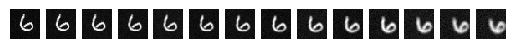

In [911]:
def plot_seq(data,train_or_test):
  if train_or_test == 'Train':
    len=14
  else :
    len=2

  i=0
  for i,seq in enumerate(data[0]):
    if i < len:
      plt.subplot(1,len,i+1)
      plt.imshow(seq, cmap='gray', interpolation='none')
      plt.axis('off')
  i=0

plot_seq(train6_arr,'Train')

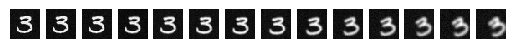

In [10]:
plot_seq(train3_arr,'Train')

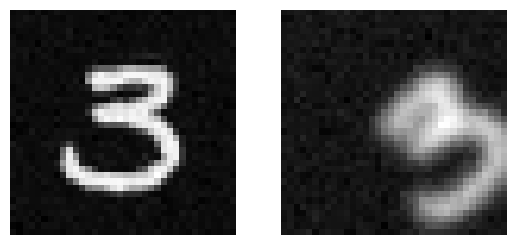

In [12]:
plot_seq(test3_arr,'Test')

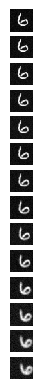

In [13]:
i=0
for i,seq in enumerate(train6_arr[0]):
  if i < 14:

    plt.subplot(14,1,i+1)
    plt.imshow(seq, cmap='gray', interpolation='none')
    plt.axis('off')

---
## **3. Simple Approach - Understanding AutoRegressive Process**

Simple-ish Deconstruction of AutoRegressive Process

---



### 3.a. Translation & Rotation

In [14]:
# Calculating the centroid (centre of mass) of one image
x1, y1 = centroid_com(train6_arr[0][0])
data = train6_arr[0][12]

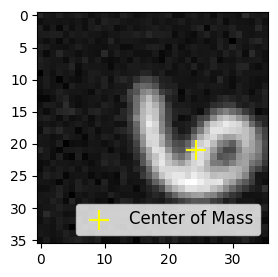

In [15]:
xycen1 = centroid_com(data)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.imshow(data, cmap='gray', interpolation='none')

ms = 200
labels = ('Center of Mass')

ax.scatter(*xycen1, color='Yellow', marker='+', s=ms, label=labels)

ax.legend(loc='lower right', fontsize=12)


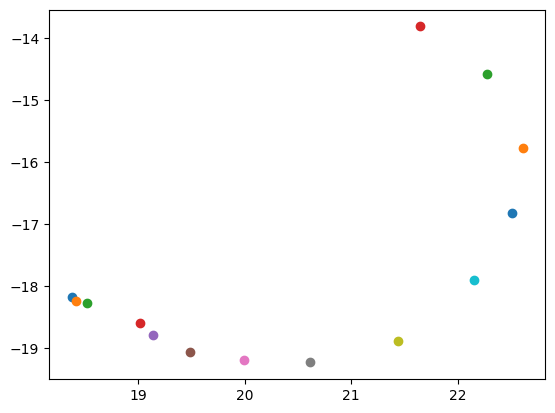

In [16]:
co_ords_t = []
co_ords=[]
for i in range(168,182):
  co_ords_t.append([i,centroid_com(train6_arr[0][i])])
  co_ords.append(centroid_com(train6_arr[0][i]))

for thing in co_ords:
  plt.scatter(thing[0],-thing[1])

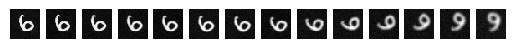

In [17]:
a=0
for i in range(168,182):

  plt.subplot(1,14,a+1)
  plt.imshow(train6_arr[0][i], cmap='gray', interpolation='none')
  a+=1
  plt.axis('off')
plt.show()

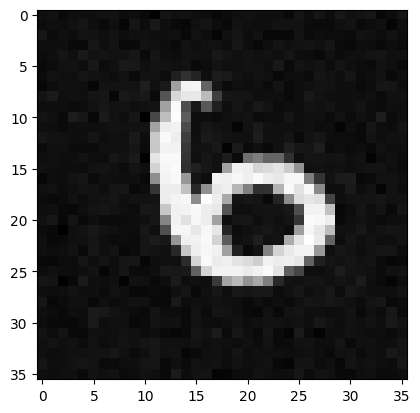

In [18]:

plt.imshow(train6_arr[0][168], cmap='gray', interpolation='none')


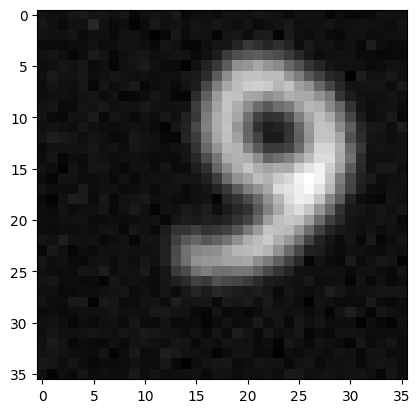

In [19]:
plt.imshow(train6_arr[0][180], cmap='gray', interpolation='none')

In [20]:
test_trans_start=train6_arr[0][168]
test_trans_end=train6_arr[0][180]
tt_sc = centroid_com(test_trans_start)
tt_ec = centroid_com(test_trans_end)
dx=tt_ec[0]-tt_sc[0]
dy=tt_ec[1]-tt_sc[1]
dx,dy

(3.90011455853692, -3.59912239969883)

In [21]:
from scipy.ndimage import rotate

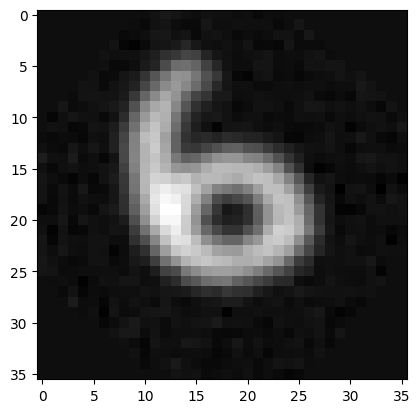

In [22]:
m = np.roll(test_trans_end, 4, axis=0) # shift 1 place in horizontal axis
m2 = np.roll(m, -4, axis=1) # shift 1 place in vert axis
rotated = rotate(m2, angle=-130,reshape=False)
plt.imshow(rotated, cmap='gray', interpolation='none')

In [23]:
test_trans_start=train6_arr[0][168]
test_trans_end=rotated
tt_sc = centroid_com(test_trans_start)
tt_ec = centroid_com(test_trans_end)
dx=tt_ec[0]-tt_sc[0]
dy=tt_ec[1]-tt_sc[1]
dx,dy

(-2.273048554739283, -0.7993234366974917)

In [235]:
m = np.roll(test_trans_end, 2, axis=0) # shift 1 place in horizontal axis
m2 = np.roll(m, 1, axis=1) # shift 1 place in vert axis
rotated = rotate(m2, angle=0,reshape=False)
plt.imshow(rotated, cmap='viridis', interpolation='none')

NameError: name 'test_trans_end' is not defined

In [25]:
rotated

array([[ 4.41006577e-21, -1.91602180e-20,  6.75515670e-20, ...,
         1.72271866e-19,  5.57646250e-20, -8.07194175e-20],
       [ 7.48926451e-22, -4.96391069e-22,  9.21256712e-21, ...,
         4.69255000e-20, -1.02361431e-19,  5.25249704e-20],
       [ 3.87630478e-23, -4.77724786e-21, -1.96586776e-20, ...,
        -5.52780755e-19,  2.03970054e-19, -7.97302574e-20],
       ...,
       [ 1.82313603e-19,  1.77130643e-19, -6.97309857e-19, ...,
        -1.04060277e-17,  1.43786995e-17, -2.00879567e-17],
       [ 5.16975254e-20,  7.94400299e-20, -9.02836977e-19, ...,
         1.35167985e-19,  2.62596948e-18, -4.27562152e-18],
       [-1.34480061e-20,  8.07413080e-20,  7.42783255e-19, ...,
         8.74889203e-19, -2.67325587e-18, -1.56511449e-18]])

KeyboardInterrupt: 

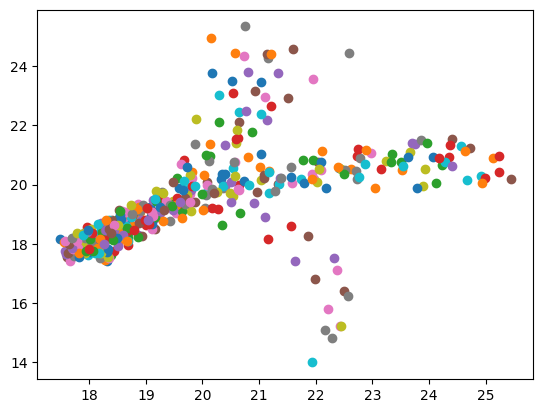

In [26]:
co_ords_t = []
co_ords=[]
for i in range(500):
  co_ords_t.append([i,centroid_com(train3_arr[0][i])])
  co_ords.append(centroid_com(train3_arr[0][i]))

for thing in co_ords:
  plt.scatter(*thing)

In [ ]:
len(train6_arr[0])

## **4. Prep Data for Modelling**

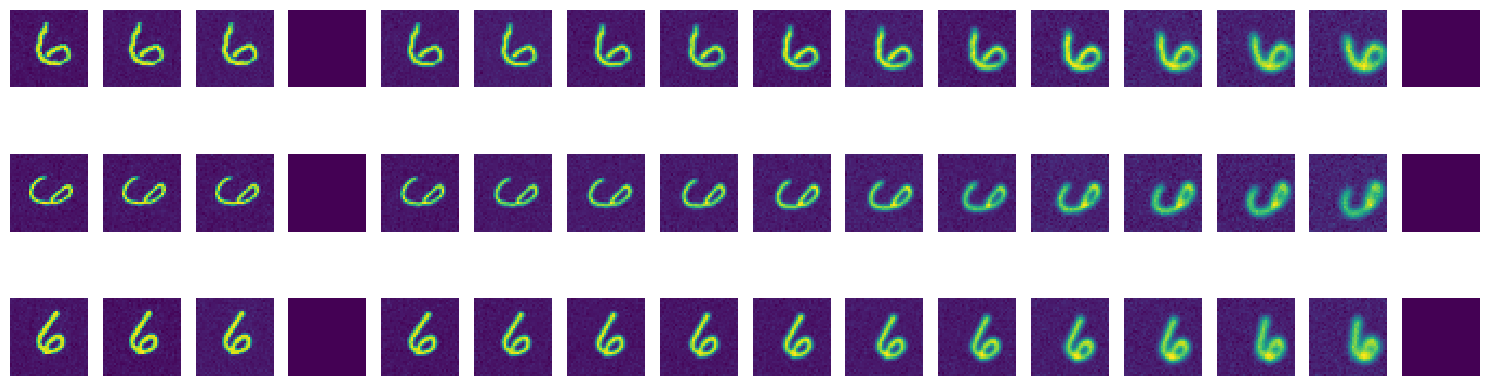

In [855]:
## for Figure 1 plot
import copy
train6_sequences = np.split(train6_arr[0], 400)
black_image = np.zeros_like(train6_sequences[0][0])

train6_for_vis = []
for sequence in train6_sequences:
    new_sequence = copy.deepcopy(sequence)
    new_sequence = np.insert(new_sequence, 3, black_image, axis=0)
    new_sequence = np.insert(new_sequence, 15, black_image, axis=0)
    train6_for_vis.append(new_sequence)

fig, axes = plt.subplots(3, len(train6_for_vis[0]), figsize=(15, 5))
for idx, sequence in enumerate(train6_for_vis):
    if idx < 3:
        for i, image in enumerate(sequence):
            axes[idx, i].imshow(image, cmap='viridis', interpolation='none')
            axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

### 4.1 Artificial Data Increase

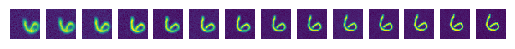

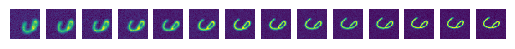

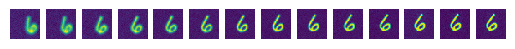

In [856]:
reversed_sequences = [seq[::-1] for seq in train6_sequences]
for idx,sequence in enumerate(reversed_sequences):
  if idx<3:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

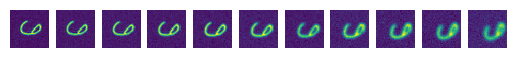

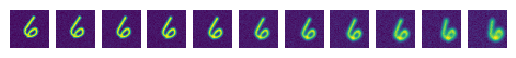

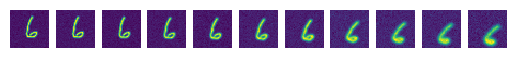

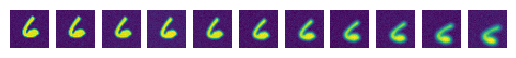

In [857]:
all_sequences = np.concatenate([train6_sequences,reversed_sequences])



filtered_sequences = []
for sequence in all_sequences:
  filtered_sequences.append(sequence[3:14])

for idx,sequence in enumerate(filtered_sequences):
  if 0<idx<5:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()



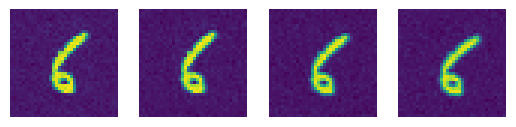

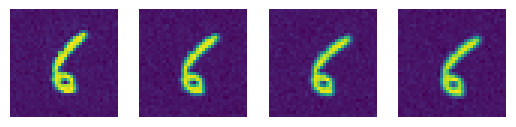

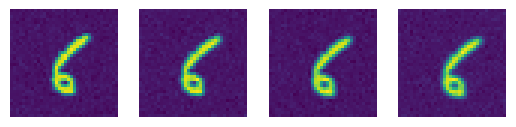

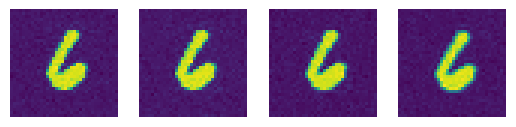

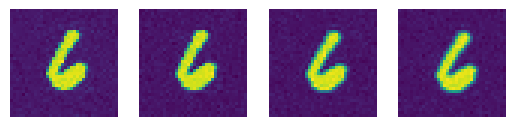

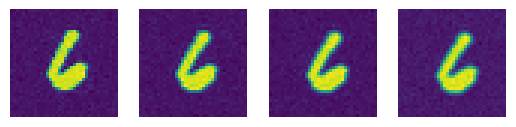

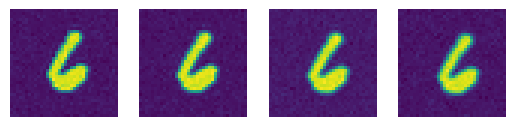

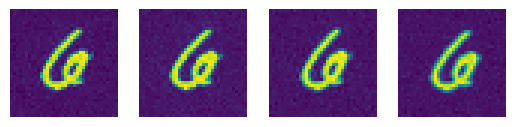

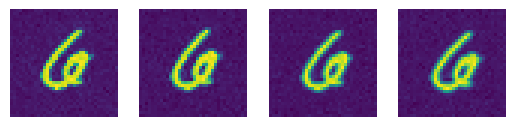

In [872]:
x_data = []
y_data = []

for sequence in train6_sequences:
    for i in range(4):
        x_data.append(sequence[i : i + 4])
        y_data.append(sequence[i + 5 : i + 9])

x_data = np.array(x_data)
y_data = np.array(y_data)

for idx,sequence in enumerate(x_data):
  if idx>400 and idx<410:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

In [869]:
x_data[0][0][0]

array([ -1.,  -5.,   3.,   0.,  -6.,   2.,   4.,   7.,  -3.,  -1.,  11.,
         1.,  -1.,   7.,   7.,  -3.,   0.,  -6.,   4.,   4.,   4.,   2.,
         0.,  -5.,   0.,   1.,   5.,  -6.,   0.,  -2.,   5.,  -5.,   6.,
         6., -11.,   3.])

In [870]:
x_data[0][1][0]

array([ 7.,  0.,  2.,  4., 10.,  5., -7., -1., -1., -2.,  0.,  0., -7.,
        2., -3., -1.,  0., -6.,  0.,  3.,  2., -4.,  4.,  1., -3., -4.,
       -1.,  3.,  0.,  0., -8.,  2., -3.,  0., -1., -2.])

In [859]:
x_data_all = []
y_data_all = []

for sequence in all_sequences:
    for i in range(4):
        x_data_all.append(sequence[i : i + 4])
        y_data_all.append(sequence[i + 5 : i + 9])

x_data_all = np.array(x_data_all)
y_data_all = np.array(y_data_all)


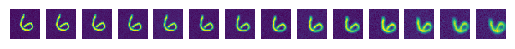

In [860]:
for idx,sequence in enumerate(train6_sequences):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

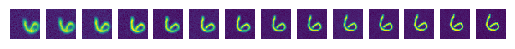

In [861]:
for idx,sequence in enumerate(reversed_sequences):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

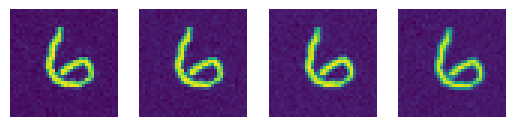

In [862]:
for idx,sequence in enumerate(x_data_all):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

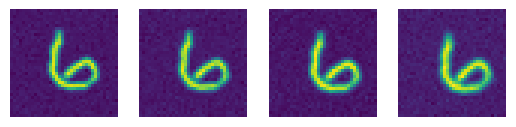

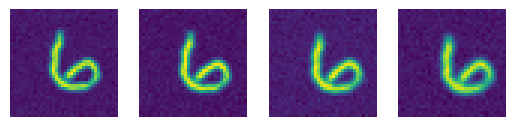

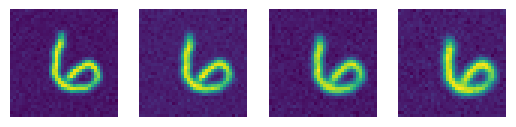

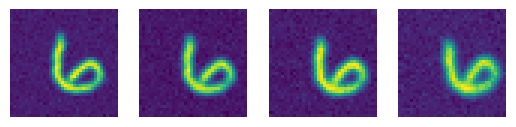

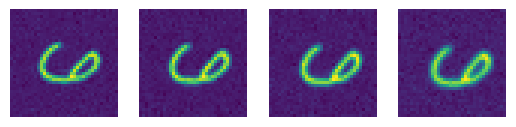

In [880]:
for idx,sequence in enumerate(y_data_all):
  if idx>-1 and idx<5:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

In [864]:
len(x_data_all)

3200

In [865]:
import random

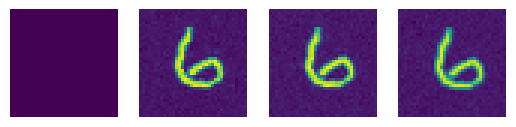

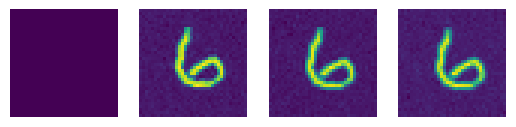

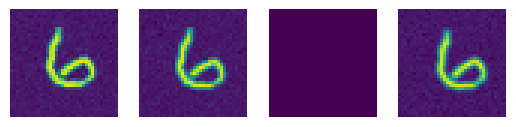

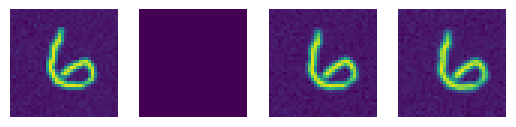

In [866]:
blank_image = np.zeros_like(x_data_all[0][0])

x_data_all_blank = copy.deepcopy(x_data_all)

for sequence in x_data_all_blank:
    indices_to_blank = random.sample(range(len(sequence)), 1)
    for index in indices_to_blank:
        sequence[index] = blank_image
for idx,sequence in enumerate(x_data_all_blank):
  if idx<4:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

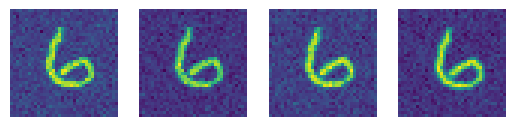

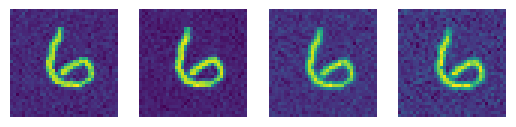

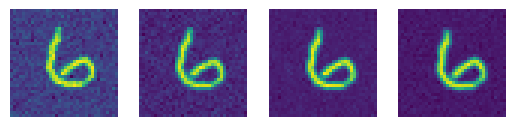

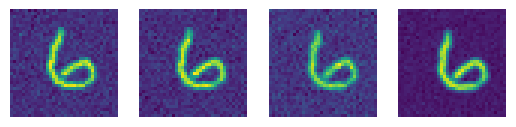

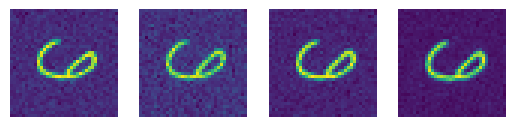

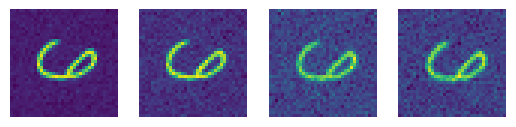

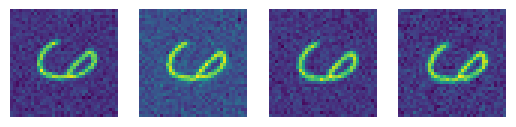

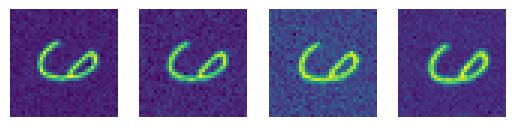

In [770]:
x_data_all_noisy = copy.deepcopy(x_data_all)
# Define the range for the random scale
min_scale = 1
max_scale = 20

for sequence in x_data_all_noisy:
    for image in sequence:
        scale = random.uniform(min_scale, max_scale)
        noise = np.random.normal(loc=0, scale=scale, size=image.shape)
        image += noise

for idx,sequence in enumerate(x_data_all_noisy):
  if idx<8:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

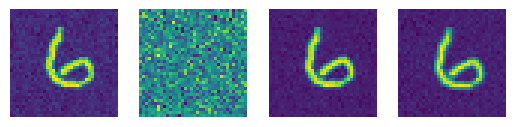

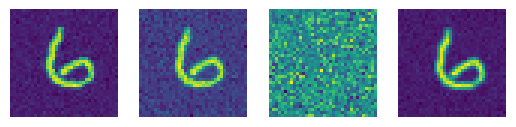

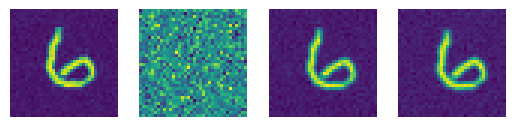

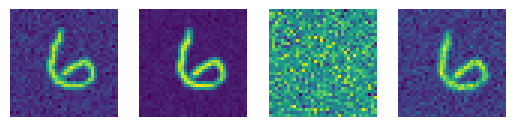

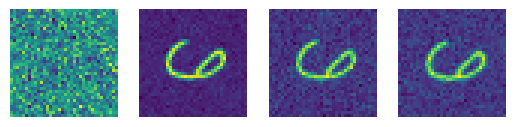

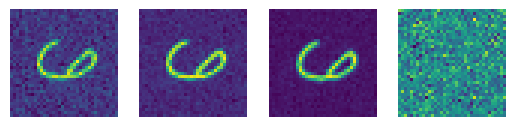

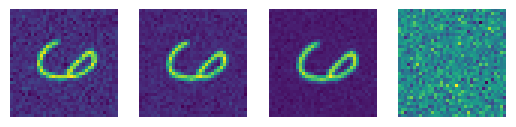

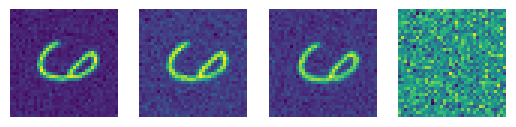

In [771]:
x_data_all_b_and_noisy = copy.deepcopy(x_data_all)

min_scale = 1
max_scale = 20

for sequence in x_data_all_b_and_noisy:
    indices_to_blank = random.sample(range(len(sequence)), 1)
    for i, image in enumerate(sequence):
        if i in indices_to_blank:
            sequence[i] = blank_image
        #else:
            scale = random.uniform(min_scale, max_scale)
            noise = np.random.normal(loc=0, scale=scale, size=image.shape)
            image += noise
        else:
            scale = random.uniform(min_scale, max_scale)
            noise = np.random.normal(loc=0, scale=scale, size=image.shape)
            image += noise
for idx,sequence in enumerate(x_data_all_b_and_noisy):
  if idx<8:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

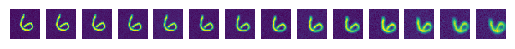

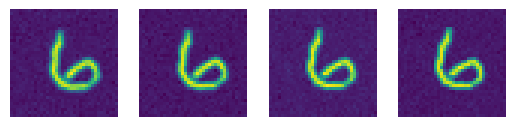

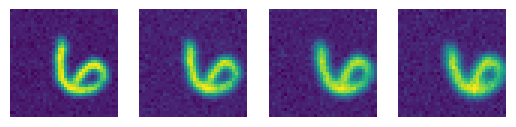

In [772]:
x_data_4idx3 = []
x_data_4idx15 = []

for sequence in train6_sequences:
      reversed=sequence[::-1]
      x_data_4idx3.append(reversed[7 : 11])
      x_data_4idx15.append(sequence[10 : 14])


for idx,sequence in enumerate(train6_sequences):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()
for idx,sequence in enumerate(x_data_4idx3):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()
for idx,sequence in enumerate(x_data_4idx15):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

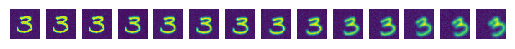

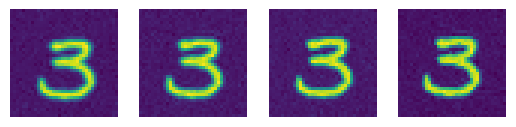

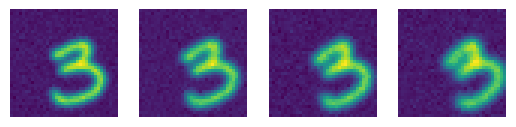

In [773]:
x3_data_4idx3 = []
x3_data_4idx15 = []

train3_sequences = np.split(train3_arr[0], 100)

for sequence in train3_sequences:
      reversed=sequence[::-1]
      x3_data_4idx3.append(reversed[7 : 11])
      x3_data_4idx15.append(sequence[10 : 14])


for idx,sequence in enumerate(train3_sequences):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()
for idx,sequence in enumerate(x3_data_4idx3):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()
for idx,sequence in enumerate(x3_data_4idx15):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

In [774]:
x_data_4idx3[0][3][0]==train6_sequences[0][3][0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [775]:
x_data_4idx15[0][3][0]==train6_sequences[0][13][0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

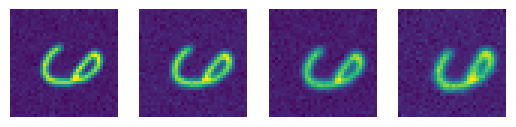

In [776]:
for idx,sequence in enumerate(y_data_all):
  if 5<idx<7:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()


In [777]:
test6_sequences = np.array(np.split(test6_arr[0], 400))

test3_sequences = np.array(np.split(test3_arr[0], 100))

modified_sequences = []

for sequence in test6_sequences:
    new_sequence = copy.deepcopy(sequence)
    new_sequence = np.append(new_sequence, [blank_image, blank_image], axis=0)
    modified_sequences.append(new_sequence)

test6_sequences = np.array(modified_sequences)
modified_sequences = []
for sequence in test3_sequences:
    new_sequence = copy.deepcopy(sequence)
    new_sequence = np.append(new_sequence, [blank_image, blank_image], axis=0)
    modified_sequences.append(new_sequence)

test3_sequences = np.array(modified_sequences)

x_data_4idx15= np.array(x_data_4idx15)
x_data_4idx3 = np.array(x_data_4idx3)
x3_data_4idx15= np.array(x3_data_4idx15)
x3_data_4idx3 = np.array(x3_data_4idx3)

In [778]:

def add_noise(data):
    data_noisy = copy.deepcopy(data)
    min_scale = 1
    max_scale = 20
    for sequence in data_noisy:
        for image in sequence:
            scale = random.uniform(min_scale, max_scale)
            noise = np.random.normal(loc=0, scale=scale, size=image.shape)
            image += noise
    return data_noisy

def add_blank(data):
    data_blank = copy.deepcopy(data)
    for sequence in data_blank:
        indices_to_blank = random.sample(range(len(sequence)), 1)
        for index in indices_to_blank:
            sequence[index] = blank_image
    return data_blank

def add_blank_and_noise(data):
    data_b_and_noisy = copy.deepcopy(data)
    min_scale = 1
    max_scale = 20
    for sequence in data_b_and_noisy:
        indices_to_blank = random.sample(range(len(sequence)), 1)
        for i, image in enumerate(sequence):
            if i in indices_to_blank:
                sequence[i] = blank_image
                scale = random.uniform(min_scale, max_scale)
                noise = np.random.normal(loc=0, scale=scale, size=image.shape)
                image += noise
            else:
                scale = random.uniform(min_scale, max_scale)
                noise = np.random.normal(loc=0, scale=scale, size=image.shape)
                image += noise
    return data_b_and_noisy

x_data_4idx15_all = copy.deepcopy(x_data_4idx15)
x_data_4idx15_noisy = add_noise(x_data_4idx15)
x_data_4idx15_blank = add_blank(x_data_4idx15)
x_data_4idx15_b_and_noisy = add_blank_and_noise(x_data_4idx15)

x_data_4idx3_all = copy.deepcopy(x_data_4idx3)
x_data_4idx3_noisy = add_noise(x_data_4idx3)
x_data_4idx3_blank = add_blank(x_data_4idx3)
x_data_4idx3_b_and_noisy = add_blank_and_noise(x_data_4idx3)

x3_data_4idx15_all = copy.deepcopy(x3_data_4idx15)
x3_data_4idx15_noisy = add_noise(x3_data_4idx15)
x3_data_4idx15_blank = add_blank(x3_data_4idx15)
x3_data_4idx15_b_and_noisy = add_blank_and_noise(x3_data_4idx15)

x3_data_4idx3_all = copy.deepcopy(x3_data_4idx3)
x3_data_4idx3_noisy = add_noise(x3_data_4idx3)
x3_data_4idx3_blank = add_blank(x3_data_4idx3)
x3_data_4idx3_b_and_noisy = add_blank_and_noise(x3_data_4idx3)

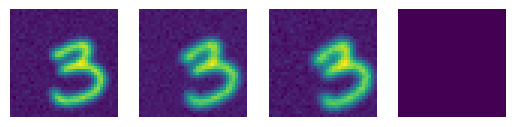

In [779]:
for idx,sequence in enumerate(x3_data_4idx15_blank):
  if idx<1:
    a = 0
    for i in range(len(sequence)):
      plt.subplot(1, len(sequence), a + 1)
      plt.imshow(sequence[i], cmap='viridis', interpolation='none')
      a += 1
      plt.axis('off')
    plt.show()

In [780]:
test_x_all = np.concatenate([x_data_4idx15,x_data_4idx3,x3_data_4idx15,x3_data_4idx3])
test_y_all = np.concatenate([test6_sequences,test6_sequences,test3_sequences,test3_sequences])

In [781]:
len(test3_sequences)


100

In [782]:
## So now we have the following:
# x_data_all - baseline
# x_data_all_blank  - 50% random drop out
# x_data_all_noisy  - random noise add to original
# x_data_all_b_and_noisy  - blank and noisy

x_data_all_everything = np.concatenate([x_data_all
                                        ,x_data_all_blank
                                        ,x_data_all_noisy
                                        ,x_data_all_b_and_noisy])
y_data_all_everything = np.concatenate([y_data_all
                                        ,y_data_all
                                        ,y_data_all
                                        ,y_data_all])


x_data_4_test = np.concatenate([
    x_data_4idx15_all
    ,x_data_4idx3_all
    ,x3_data_4idx15_all
    ,x3_data_4idx3_all
    ,x_data_4idx15_noisy
    ,x_data_4idx3_noisy
    ,x3_data_4idx15_noisy
    ,x3_data_4idx3_noisy
    ,x_data_4idx15_blank
    ,x_data_4idx3_blank
    ,x3_data_4idx15_blank
    ,x3_data_4idx3_blank
    ,x_data_4idx15_b_and_noisy
    ,x_data_4idx3_b_and_noisy
    ,x3_data_4idx15_b_and_noisy
    ,x3_data_4idx3_b_and_noisy
])
y_data_4_test = np.concatenate([
    test6_sequences
    ,test6_sequences
    ,test3_sequences
    ,test3_sequences
    ,test6_sequences
    ,test6_sequences
    ,test3_sequences
    ,test3_sequences
    ,test6_sequences
    ,test6_sequences
    ,test3_sequences
    ,test3_sequences
    ,test6_sequences
    ,test6_sequences
    ,test3_sequences
    ,test3_sequences])



In [783]:
print(len(x_data_4_test),len(y_data_4_test))

4000 4000


In [724]:
#### shuffle the trainning data

indices = np.arange(x_data_all_everything.shape[0])
np.random.shuffle(indices)
#x_data_all = x_data_all_everything[indices]
#y_data_all = y_data_all_everything[indices]

#indices = np.arange(x_data_all_everything.shape[0])
#np.random.shuffle(indices)
#x_data_all = x_data_all_everything[indices]
#y_data_all = y_data_all_everything[indices]

In [787]:
indices = np.arange(x_data_all.shape[0])
np.random.shuffle(indices)
x_data_all = x_data_all[indices]
y_data_all = y_data_all[indices]

In [788]:
x_data_all.shape[0]

3200

In [789]:
#x_data_all_everything.shape[0]

12800

In [819]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(
    x_data_all, y_data_all, test_size=0.5, random_state=42
)

#val_x, test_x, val_y, test_y = train_test_split(
#    remaining_x, remaining_y, test_size=0.5, random_state=42
#)

train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)
#test_x = np.array(test_x)
#test_y = np.array(test_y)



In [820]:
print(train_x.shape)
## may have issue with

(1600, 4, 36, 36)


## **5.SimVp**

In [821]:
pre_seq_length = 4
aft_seq_length = 4

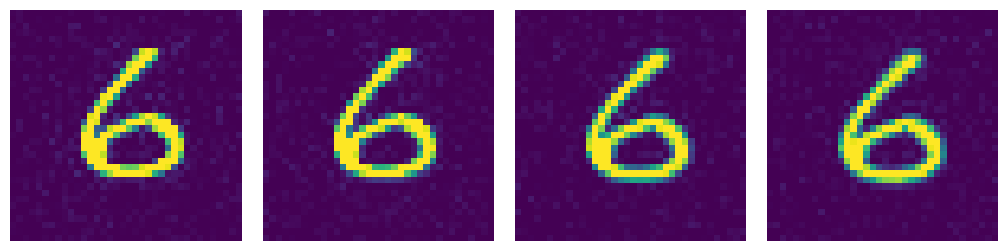

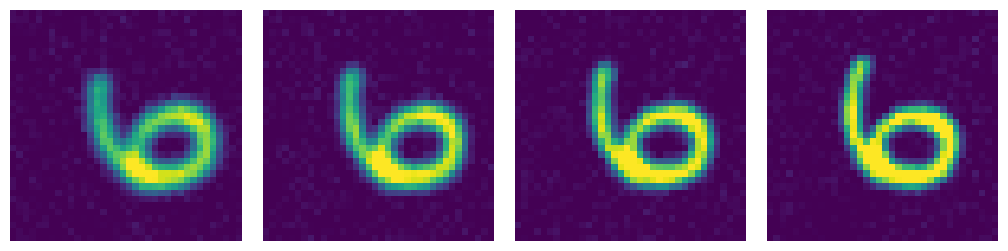

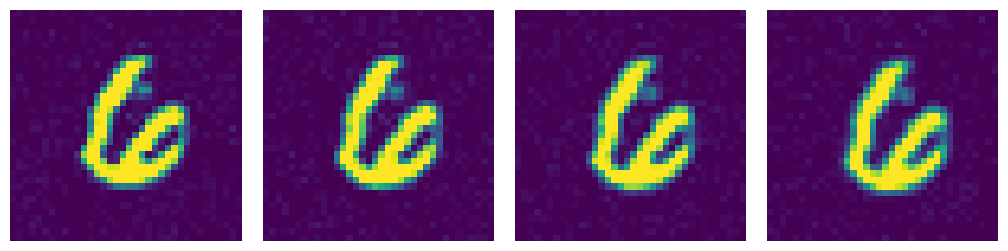

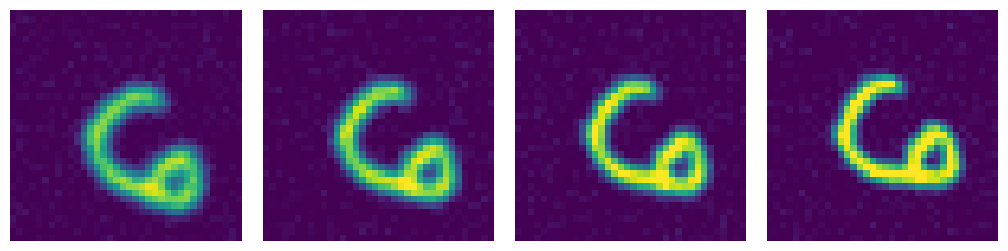

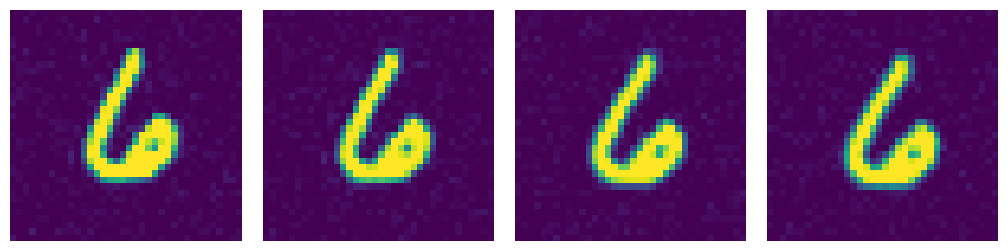

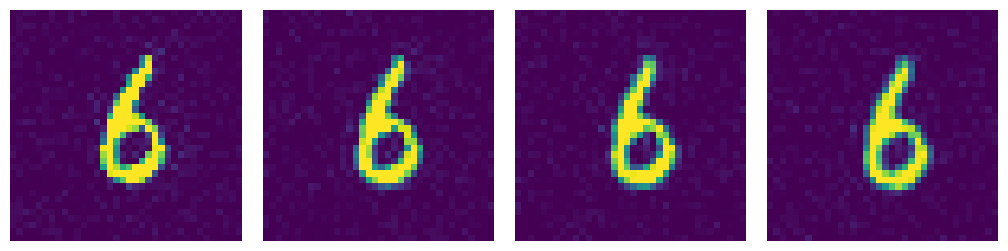

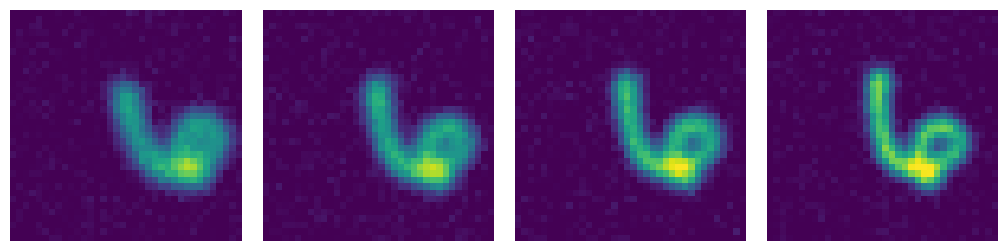

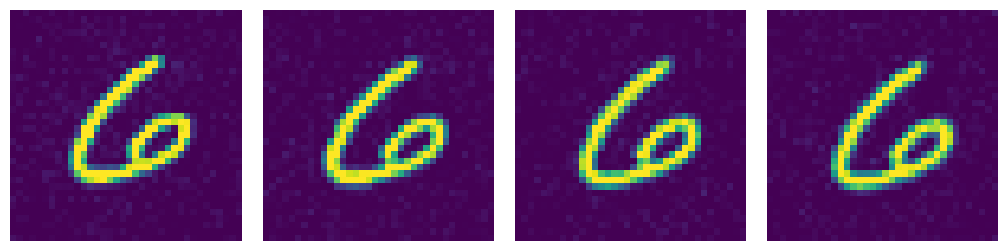

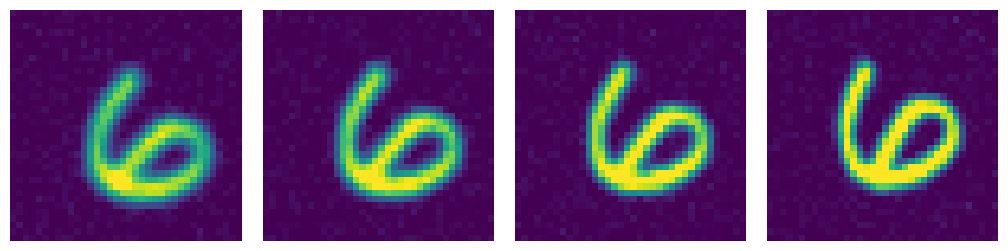

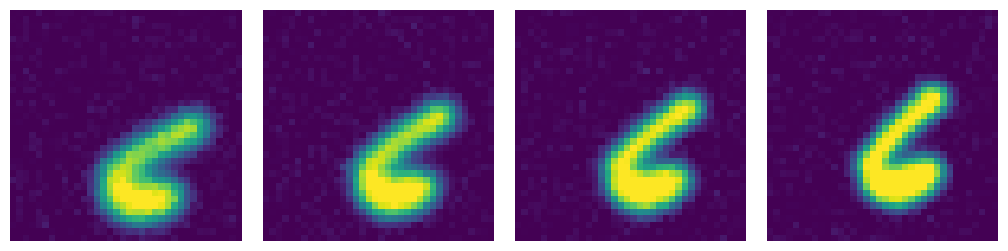

test


In [822]:
from openstl.utils import show_video_line

# show the given frames from an example
for i in range(35,45):
  example_idx = i

  show_video_line(train_x[example_idx], cmap = 'viridis', ncols=pre_seq_length, vmax=200, cbar=False, out_path=None, format='png', use_rgb=False)
print('test')
for i in range(46,45):
  example_idx = i

  show_video_line(train_y[example_idx], cmap = 'viridis', ncols=pre_seq_length, vmax=200, cbar=False, out_path=None, format='png', use_rgb=False)

#show_video_line(test3_x[example_idx], ncols=pre_seq_length, vmax=200, cbar=False, out_path=None, format='png', use_rgb=False)

In [823]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name='custom'):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        # Add channel dimension
        data = data.unsqueeze(1)
        labels = labels.unsqueeze(1)
        return data, labels

In [824]:
batch_size = 16

In [825]:
train_set = CustomDataset(X=train_x, Y=train_y)
val_set = CustomDataset(X=val_x, Y=val_y)
test_set = CustomDataset(X=x_data_4_test, Y=y_data_4_test)

In [826]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True) ## maybe important to set to false

In [827]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 500,
    'lr': 0.001,
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [4,1,32, 32],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are:
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters
    # 'config_file': 'configs/custom/example_model.py',

    # Here, we directly set these parameters
    'model_type': 'gSTA', #IncepU [ 20it/spr gSTA? 30it/s
    'N_S': 2,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

*note: need to replace all timm.layers WITH timm.models.layers and _efficientnet_blocks with efficientnet_blocks

In [828]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update default parameters
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test), strategy='auto')

INFO: Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [829]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | SimVP_Model | 11.1 M | train
1 | criterion | MSELoss     | 0      | train
--------------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.268    Total estimated model params size (MB)
191       Modules in train mode
0         Modules in eval mode


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_12.2.r12.2/compiler.33191640_0
GPU 0: NVIDIA A100-SXM4-40GB
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.5.1+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 100: 'val_loss' reached 3359.20117 (best 3359.20117), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=00-val_loss=3359.201.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Lr: 0.0000404 | Train Loss: 3372.1225586 | Vali Loss: 3281.0021973


INFO: Epoch 1, global step 200: 'val_loss' reached 3281.00220 (best 3281.00220), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=01-val_loss=3281.002.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Lr: 0.0000409 | Train Loss: 3234.4294434 | Vali Loss: 3242.5444336


INFO: Epoch 2, global step 300: 'val_loss' reached 3242.54443 (best 3242.54443), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=02-val_loss=3242.544.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Lr: 0.0000417 | Train Loss: 3184.9987793 | Vali Loss: 3211.5202637


INFO: Epoch 3, global step 400: 'val_loss' reached 3211.52026 (best 3211.52026), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=03-val_loss=3211.520.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Lr: 0.0000426 | Train Loss: 3151.2141113 | Vali Loss: 3183.6237793


INFO: Epoch 4, global step 500: 'val_loss' reached 3183.62378 (best 3183.62378), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=04-val_loss=3183.624.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Lr: 0.0000438 | Train Loss: 3122.3708496 | Vali Loss: 3156.3623047


INFO: Epoch 5, global step 600: 'val_loss' reached 3156.36230 (best 3156.36230), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=05-val_loss=3156.362.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Lr: 0.0000451 | Train Loss: 3094.9421387 | Vali Loss: 3129.5427246


INFO: Epoch 6, global step 700: 'val_loss' reached 3129.54272 (best 3129.54272), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=06-val_loss=3129.543.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Lr: 0.0000467 | Train Loss: 3067.4887695 | Vali Loss: 3101.1547852


INFO: Epoch 7, global step 800: 'val_loss' reached 3101.15479 (best 3101.15479), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=07-val_loss=3101.155.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Lr: 0.0000485 | Train Loss: 3040.2602539 | Vali Loss: 3072.4250488


INFO: Epoch 8, global step 900: 'val_loss' reached 3072.42505 (best 3072.42505), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=08-val_loss=3072.425.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Lr: 0.0000505 | Train Loss: 3011.7565918 | Vali Loss: 3042.8842773


INFO: Epoch 9, global step 1000: 'val_loss' reached 3042.88428 (best 3042.88428), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=09-val_loss=3042.884.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Lr: 0.0000527 | Train Loss: 2982.5405273 | Vali Loss: 3013.0158691


INFO: Epoch 10, global step 1100: 'val_loss' reached 3013.01587 (best 3013.01587), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=10-val_loss=3013.016.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Lr: 0.0000551 | Train Loss: 2951.1440430 | Vali Loss: 2981.6491699


INFO: Epoch 11, global step 1200: 'val_loss' reached 2981.64917 (best 2981.64917), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=11-val_loss=2981.649.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Lr: 0.0000577 | Train Loss: 2918.8437500 | Vali Loss: 2946.9943848


INFO: Epoch 12, global step 1300: 'val_loss' reached 2946.99438 (best 2946.99438), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=12-val_loss=2946.994.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: Lr: 0.0000605 | Train Loss: 2884.4687500 | Vali Loss: 2910.6008301


INFO: Epoch 13, global step 1400: 'val_loss' reached 2910.60083 (best 2910.60083), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=13-val_loss=2910.601.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: Lr: 0.0000635 | Train Loss: 2847.6752930 | Vali Loss: 2871.2150879


INFO: Epoch 14, global step 1500: 'val_loss' reached 2871.21509 (best 2871.21509), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=14-val_loss=2871.215.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: Lr: 0.0000667 | Train Loss: 2808.7993164 | Vali Loss: 2830.3366699


INFO: Epoch 15, global step 1600: 'val_loss' reached 2830.33667 (best 2830.33667), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=15-val_loss=2830.337.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: Lr: 0.0000701 | Train Loss: 2766.8012695 | Vali Loss: 2790.4628906


INFO: Epoch 16, global step 1700: 'val_loss' reached 2790.46289 (best 2790.46289), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=16-val_loss=2790.463.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: Lr: 0.0000737 | Train Loss: 2722.9672852 | Vali Loss: 2744.4655762


INFO: Epoch 17, global step 1800: 'val_loss' reached 2744.46558 (best 2744.46558), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=17-val_loss=2744.466.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: Lr: 0.0000775 | Train Loss: 2677.4160156 | Vali Loss: 2695.8471680


INFO: Epoch 18, global step 1900: 'val_loss' reached 2695.84717 (best 2695.84717), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=18-val_loss=2695.847.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: Lr: 0.0000815 | Train Loss: 2628.2221680 | Vali Loss: 2642.7468262


INFO: Epoch 19, global step 2000: 'val_loss' reached 2642.74683 (best 2642.74683), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=19-val_loss=2642.747.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: Lr: 0.0000857 | Train Loss: 2574.6843262 | Vali Loss: 2590.1166992


INFO: Epoch 20, global step 2100: 'val_loss' reached 2590.11670 (best 2590.11670), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=20-val_loss=2590.117.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: Lr: 0.0000901 | Train Loss: 2520.2897949 | Vali Loss: 2531.4589844


INFO: Epoch 21, global step 2200: 'val_loss' reached 2531.45898 (best 2531.45898), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=21-val_loss=2531.459.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: Lr: 0.0000946 | Train Loss: 2462.2861328 | Vali Loss: 2471.9895020


INFO: Epoch 22, global step 2300: 'val_loss' reached 2471.98950 (best 2471.98950), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=22-val_loss=2471.990.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: Lr: 0.0000994 | Train Loss: 2401.8591309 | Vali Loss: 2412.6230469


INFO: Epoch 23, global step 2400: 'val_loss' reached 2412.62305 (best 2412.62305), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=23-val_loss=2412.623.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: Lr: 0.0001043 | Train Loss: 2339.7797852 | Vali Loss: 2345.2111816


INFO: Epoch 24, global step 2500: 'val_loss' reached 2345.21118 (best 2345.21118), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=24-val_loss=2345.211.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: Lr: 0.0001094 | Train Loss: 2272.2680664 | Vali Loss: 2278.4367676


INFO: Epoch 25, global step 2600: 'val_loss' reached 2278.43677 (best 2278.43677), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=25-val_loss=2278.437.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: Lr: 0.0001147 | Train Loss: 2204.2202148 | Vali Loss: 2205.2336426


INFO: Epoch 26, global step 2700: 'val_loss' reached 2205.23364 (best 2205.23364), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=26-val_loss=2205.234.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: Lr: 0.0001202 | Train Loss: 2131.7143555 | Vali Loss: 2130.5710449


INFO: Epoch 27, global step 2800: 'val_loss' reached 2130.57104 (best 2130.57104), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=27-val_loss=2130.571.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: Lr: 0.0001259 | Train Loss: 2056.3525391 | Vali Loss: 2054.1789551


INFO: Epoch 28, global step 2900: 'val_loss' reached 2054.17896 (best 2054.17896), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=28-val_loss=2054.179.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: Lr: 0.0001317 | Train Loss: 1977.5987549 | Vali Loss: 1971.8609619


INFO: Epoch 29, global step 3000: 'val_loss' reached 1971.86096 (best 1971.86096), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=29-val_loss=1971.861.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: Lr: 0.0001377 | Train Loss: 1898.1406250 | Vali Loss: 1887.0831299


INFO: Epoch 30, global step 3100: 'val_loss' reached 1887.08313 (best 1887.08313), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=30-val_loss=1887.083.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: Lr: 0.0001438 | Train Loss: 1811.1995850 | Vali Loss: 1804.0222168


INFO: Epoch 31, global step 3200: 'val_loss' reached 1804.02222 (best 1804.02222), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=31-val_loss=1804.022.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: Lr: 0.0001502 | Train Loss: 1726.1147461 | Vali Loss: 1717.4620361


INFO: Epoch 32, global step 3300: 'val_loss' reached 1717.46204 (best 1717.46204), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=32-val_loss=1717.462.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: Lr: 0.0001567 | Train Loss: 1636.9907227 | Vali Loss: 1625.5877686


INFO: Epoch 33, global step 3400: 'val_loss' reached 1625.58777 (best 1625.58777), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=33-val_loss=1625.588.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: Lr: 0.0001633 | Train Loss: 1546.7746582 | Vali Loss: 1540.7062988


INFO: Epoch 34, global step 3500: 'val_loss' reached 1540.70630 (best 1540.70630), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=34-val_loss=1540.706.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: Lr: 0.0001701 | Train Loss: 1454.6945801 | Vali Loss: 1447.0274658


INFO: Epoch 35, global step 3600: 'val_loss' reached 1447.02747 (best 1447.02747), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=35-val_loss=1447.027.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: Lr: 0.0001771 | Train Loss: 1363.3430176 | Vali Loss: 1361.5982666


INFO: Epoch 36, global step 3700: 'val_loss' reached 1361.59827 (best 1361.59827), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=36-val_loss=1361.598.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: Lr: 0.0001842 | Train Loss: 1269.1893311 | Vali Loss: 1268.3863525


INFO: Epoch 37, global step 3800: 'val_loss' reached 1268.38635 (best 1268.38635), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=37-val_loss=1268.386.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: Lr: 0.0001914 | Train Loss: 1175.1271973 | Vali Loss: 1179.7282715


INFO: Epoch 38, global step 3900: 'val_loss' reached 1179.72827 (best 1179.72827), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=38-val_loss=1179.728.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: Lr: 0.0001988 | Train Loss: 1080.7777100 | Vali Loss: 1093.5898438


INFO: Epoch 39, global step 4000: 'val_loss' reached 1093.58984 (best 1093.58984), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=39-val_loss=1093.590.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: Lr: 0.0002064 | Train Loss: 990.8449097 | Vali Loss: 1006.8690796


INFO: Epoch 40, global step 4100: 'val_loss' reached 1006.86908 (best 1006.86908), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=40-val_loss=1006.869.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: Lr: 0.0002141 | Train Loss: 901.7706909 | Vali Loss: 924.5421143


INFO: Epoch 41, global step 4200: 'val_loss' reached 924.54211 (best 924.54211), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=41-val_loss=924.542.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: Lr: 0.0002219 | Train Loss: 812.6724854 | Vali Loss: 845.5357666


INFO: Epoch 42, global step 4300: 'val_loss' reached 845.53577 (best 845.53577), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=42-val_loss=845.536.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: Lr: 0.0002298 | Train Loss: 727.3601685 | Vali Loss: 782.7949219


INFO: Epoch 43, global step 4400: 'val_loss' reached 782.79492 (best 782.79492), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=43-val_loss=782.795.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: Lr: 0.0002379 | Train Loss: 651.9009399 | Vali Loss: 709.0395508


INFO: Epoch 44, global step 4500: 'val_loss' reached 709.03955 (best 709.03955), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=44-val_loss=709.040.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: Lr: 0.0002461 | Train Loss: 581.3958740 | Vali Loss: 647.4696655


INFO: Epoch 45, global step 4600: 'val_loss' reached 647.46967 (best 647.46967), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=45-val_loss=647.470.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: Lr: 0.0002544 | Train Loss: 511.1624146 | Vali Loss: 598.4133301


INFO: Epoch 46, global step 4700: 'val_loss' reached 598.41333 (best 598.41333), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=46-val_loss=598.413.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: Lr: 0.0002628 | Train Loss: 448.2124329 | Vali Loss: 545.3627930


INFO: Epoch 47, global step 4800: 'val_loss' reached 545.36279 (best 545.36279), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=47-val_loss=545.363.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: Lr: 0.0002714 | Train Loss: 393.0729980 | Vali Loss: 505.9549255


INFO: Epoch 48, global step 4900: 'val_loss' reached 505.95493 (best 505.95493), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=48-val_loss=505.955.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49: Lr: 0.0002800 | Train Loss: 343.1514893 | Vali Loss: 469.4674683


INFO: Epoch 49, global step 5000: 'val_loss' reached 469.46747 (best 469.46747), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=49-val_loss=469.467.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50: Lr: 0.0002888 | Train Loss: 300.6523438 | Vali Loss: 436.3575134


INFO: Epoch 50, global step 5100: 'val_loss' reached 436.35751 (best 436.35751), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=50-val_loss=436.358.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51: Lr: 0.0002976 | Train Loss: 263.0409851 | Vali Loss: 405.4221497


INFO: Epoch 51, global step 5200: 'val_loss' reached 405.42215 (best 405.42215), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=51-val_loss=405.422.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52: Lr: 0.0003066 | Train Loss: 229.0540161 | Vali Loss: 376.5646973


INFO: Epoch 52, global step 5300: 'val_loss' reached 376.56470 (best 376.56470), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=52-val_loss=376.565.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53: Lr: 0.0003157 | Train Loss: 199.8492126 | Vali Loss: 356.6468811


INFO: Epoch 53, global step 5400: 'val_loss' reached 356.64688 (best 356.64688), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=53-val_loss=356.647.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54: Lr: 0.0003248 | Train Loss: 178.4377899 | Vali Loss: 350.6229553


INFO: Epoch 54, global step 5500: 'val_loss' reached 350.62296 (best 350.62296), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=54-val_loss=350.623.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55: Lr: 0.0003340 | Train Loss: 156.8040314 | Vali Loss: 334.1582336


INFO: Epoch 55, global step 5600: 'val_loss' reached 334.15823 (best 334.15823), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=55-val_loss=334.158.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56: Lr: 0.0003433 | Train Loss: 138.8013916 | Vali Loss: 317.0167847


INFO: Epoch 56, global step 5700: 'val_loss' reached 317.01678 (best 317.01678), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=56-val_loss=317.017.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57: Lr: 0.0003527 | Train Loss: 126.4469910 | Vali Loss: 325.9878235


INFO: Epoch 57, global step 5800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58: Lr: 0.0003622 | Train Loss: 112.6653976 | Vali Loss: 305.3751831


INFO: Epoch 58, global step 5900: 'val_loss' reached 305.37518 (best 305.37518), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=58-val_loss=305.375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59: Lr: 0.0003717 | Train Loss: 105.4476471 | Vali Loss: 295.7467041


INFO: Epoch 59, global step 6000: 'val_loss' reached 295.74670 (best 295.74670), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=59-val_loss=295.747.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60: Lr: 0.0003813 | Train Loss: 98.3518753 | Vali Loss: 306.0722046


INFO: Epoch 60, global step 6100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61: Lr: 0.0003910 | Train Loss: 90.8987122 | Vali Loss: 285.5875854


INFO: Epoch 61, global step 6200: 'val_loss' reached 285.58759 (best 285.58759), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=61-val_loss=285.588.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62: Lr: 0.0004007 | Train Loss: 85.5009308 | Vali Loss: 290.3407898


INFO: Epoch 62, global step 6300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63: Lr: 0.0004104 | Train Loss: 77.6956558 | Vali Loss: 277.9812012


INFO: Epoch 63, global step 6400: 'val_loss' reached 277.98120 (best 277.98120), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=63-val_loss=277.981.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64: Lr: 0.0004202 | Train Loss: 74.6936798 | Vali Loss: 278.5110168


INFO: Epoch 64, global step 6500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65: Lr: 0.0004301 | Train Loss: 68.8892517 | Vali Loss: 274.0387573


INFO: Epoch 65, global step 6600: 'val_loss' reached 274.03876 (best 274.03876), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=65-val_loss=274.039.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66: Lr: 0.0004400 | Train Loss: 66.8237076 | Vali Loss: 280.0302429


INFO: Epoch 66, global step 6700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67: Lr: 0.0004499 | Train Loss: 61.3048439 | Vali Loss: 265.6470642


INFO: Epoch 67, global step 6800: 'val_loss' reached 265.64706 (best 265.64706), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=67-val_loss=265.647.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68: Lr: 0.0004599 | Train Loss: 61.1075287 | Vali Loss: 276.8423157


INFO: Epoch 68, global step 6900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69: Lr: 0.0004699 | Train Loss: 61.8363914 | Vali Loss: 274.0072021


INFO: Epoch 69, global step 7000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70: Lr: 0.0004799 | Train Loss: 62.1842537 | Vali Loss: 262.4497986


INFO: Epoch 70, global step 7100: 'val_loss' reached 262.44980 (best 262.44980), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=70-val_loss=262.450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71: Lr: 0.0004899 | Train Loss: 58.9377136 | Vali Loss: 273.3721008


INFO: Epoch 71, global step 7200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72: Lr: 0.0004999 | Train Loss: 55.1145515 | Vali Loss: 278.0055542


INFO: Epoch 72, global step 7300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73: Lr: 0.0005100 | Train Loss: 55.9717636 | Vali Loss: 259.0340576


INFO: Epoch 73, global step 7400: 'val_loss' reached 259.03406 (best 259.03406), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=73-val_loss=259.034.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74: Lr: 0.0005201 | Train Loss: 54.5824738 | Vali Loss: 269.5484314


INFO: Epoch 74, global step 7500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75: Lr: 0.0005301 | Train Loss: 52.0493469 | Vali Loss: 257.2286987


INFO: Epoch 75, global step 7600: 'val_loss' reached 257.22870 (best 257.22870), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=75-val_loss=257.229.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76: Lr: 0.0005402 | Train Loss: 50.2020073 | Vali Loss: 254.5735779


INFO: Epoch 76, global step 7700: 'val_loss' reached 254.57358 (best 254.57358), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=76-val_loss=254.574.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77: Lr: 0.0005502 | Train Loss: 51.6573524 | Vali Loss: 249.7421265


INFO: Epoch 77, global step 7800: 'val_loss' reached 249.74213 (best 249.74213), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=77-val_loss=249.742.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78: Lr: 0.0005602 | Train Loss: 48.3188972 | Vali Loss: 268.6557312


INFO: Epoch 78, global step 7900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79: Lr: 0.0005702 | Train Loss: 48.1475945 | Vali Loss: 262.8200684


INFO: Epoch 79, global step 8000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80: Lr: 0.0005802 | Train Loss: 48.5116692 | Vali Loss: 273.8617249


INFO: Epoch 80, global step 8100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81: Lr: 0.0005902 | Train Loss: 50.0365524 | Vali Loss: 277.4326172


INFO: Epoch 81, global step 8200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82: Lr: 0.0006001 | Train Loss: 49.4723778 | Vali Loss: 270.1524658


INFO: Epoch 82, global step 8300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83: Lr: 0.0006100 | Train Loss: 46.4835510 | Vali Loss: 265.0987854


INFO: Epoch 83, global step 8400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84: Lr: 0.0006199 | Train Loss: 46.2236328 | Vali Loss: 255.4950714


INFO: Epoch 84, global step 8500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85: Lr: 0.0006297 | Train Loss: 45.9068604 | Vali Loss: 263.6463013


INFO: Epoch 85, global step 8600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86: Lr: 0.0006394 | Train Loss: 42.5416908 | Vali Loss: 254.2783966


INFO: Epoch 86, global step 8700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87: Lr: 0.0006491 | Train Loss: 41.5308685 | Vali Loss: 250.7322693


INFO: Epoch 87, global step 8800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88: Lr: 0.0006588 | Train Loss: 40.3951912 | Vali Loss: 254.9930267


INFO: Epoch 88, global step 8900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89: Lr: 0.0006684 | Train Loss: 40.7335205 | Vali Loss: 278.3002014


INFO: Epoch 89, global step 9000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90: Lr: 0.0006779 | Train Loss: 42.1435738 | Vali Loss: 276.5798340


INFO: Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91: Lr: 0.0006874 | Train Loss: 43.7387009 | Vali Loss: 270.3757324


INFO: Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92: Lr: 0.0006968 | Train Loss: 43.1752930 | Vali Loss: 267.0718079


INFO: Epoch 92, global step 9300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93: Lr: 0.0007061 | Train Loss: 43.9249268 | Vali Loss: 259.2406006


INFO: Epoch 93, global step 9400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94: Lr: 0.0007153 | Train Loss: 44.8597870 | Vali Loss: 265.2333679


INFO: Epoch 94, global step 9500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95: Lr: 0.0007244 | Train Loss: 45.3575821 | Vali Loss: 258.5236816


INFO: Epoch 95, global step 9600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96: Lr: 0.0007335 | Train Loss: 44.5655289 | Vali Loss: 272.8326416


INFO: Epoch 96, global step 9700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97: Lr: 0.0007424 | Train Loss: 46.1865425 | Vali Loss: 251.1541595


INFO: Epoch 97, global step 9800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98: Lr: 0.0007513 | Train Loss: 43.6352196 | Vali Loss: 264.9756165


INFO: Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99: Lr: 0.0007601 | Train Loss: 41.3871765 | Vali Loss: 417.1648560


INFO: Epoch 99, global step 10000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 100: Lr: 0.0007687 | Train Loss: 130.7702332 | Vali Loss: 315.5370483


INFO: Epoch 100, global step 10100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 101: Lr: 0.0007773 | Train Loss: 160.0886688 | Vali Loss: 253.6103668


INFO: Epoch 101, global step 10200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 102: Lr: 0.0007857 | Train Loss: 85.4636307 | Vali Loss: 255.6187744


INFO: Epoch 102, global step 10300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 103: Lr: 0.0007940 | Train Loss: 53.9595795 | Vali Loss: 245.0973206


INFO: Epoch 103, global step 10400: 'val_loss' reached 245.09732 (best 245.09732), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=103-val_loss=245.097.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 104: Lr: 0.0008022 | Train Loss: 42.1856575 | Vali Loss: 246.9192200


INFO: Epoch 104, global step 10500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 105: Lr: 0.0008103 | Train Loss: 36.8581467 | Vali Loss: 248.2094879


INFO: Epoch 105, global step 10600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 106: Lr: 0.0008182 | Train Loss: 33.8736916 | Vali Loss: 245.9831390


INFO: Epoch 106, global step 10700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 107: Lr: 0.0008260 | Train Loss: 33.4261589 | Vali Loss: 245.0020294


INFO: Epoch 107, global step 10800: 'val_loss' reached 245.00203 (best 245.00203), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=107-val_loss=245.002.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 108: Lr: 0.0008337 | Train Loss: 31.6571026 | Vali Loss: 249.1971893


INFO: Epoch 108, global step 10900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 109: Lr: 0.0008412 | Train Loss: 30.6320248 | Vali Loss: 243.3864594


INFO: Epoch 109, global step 11000: 'val_loss' reached 243.38646 (best 243.38646), saving model to '/content/OpenSTL/work_dirs/custom_exp/checkpoints/best-epoch=109-val_loss=243.386.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 110: Lr: 0.0008486 | Train Loss: 30.1360836 | Vali Loss: 245.9787750


INFO: Epoch 110, global step 11100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 111: Lr: 0.0008559 | Train Loss: 30.2952805 | Vali Loss: 255.0430450


INFO: Epoch 111, global step 11200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 112: Lr: 0.0008630 | Train Loss: 30.6067219 | Vali Loss: 251.7607269


INFO: Epoch 112, global step 11300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 113: Lr: 0.0008700 | Train Loss: 31.3220940 | Vali Loss: 253.2283173


INFO: Epoch 113, global step 11400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 114: Lr: 0.0008768 | Train Loss: 32.0148544 | Vali Loss: 248.1131897


INFO: Epoch 114, global step 11500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 115: Lr: 0.0008834 | Train Loss: 32.1104889 | Vali Loss: 247.8219757


INFO: Epoch 115, global step 11600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 116: Lr: 0.0008899 | Train Loss: 32.1769714 | Vali Loss: 245.0628357


INFO: Epoch 116, global step 11700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 117: Lr: 0.0008962 | Train Loss: 32.5821228 | Vali Loss: 251.2957458


INFO: Epoch 117, global step 11800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 118: Lr: 0.0009024 | Train Loss: 32.3048630 | Vali Loss: 246.8148651


INFO: Epoch 118, global step 11900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 119: Lr: 0.0009084 | Train Loss: 32.2829285 | Vali Loss: 253.3982849


INFO: Epoch 119, global step 12000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 120: Lr: 0.0009142 | Train Loss: 32.1957207 | Vali Loss: 254.4199219


INFO: Epoch 120, global step 12100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 121: Lr: 0.0009198 | Train Loss: 35.0449638 | Vali Loss: 247.9727936


INFO: Epoch 121, global step 12200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 122: Lr: 0.0009253 | Train Loss: 36.3031578 | Vali Loss: 245.7242737


INFO: Epoch 122, global step 12300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 123: Lr: 0.0009306 | Train Loss: 36.5925674 | Vali Loss: 251.4878082


INFO: Epoch 123, global step 12400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 124: Lr: 0.0009357 | Train Loss: 36.7528419 | Vali Loss: 254.1985168


INFO: Epoch 124, global step 12500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 125: Lr: 0.0009407 | Train Loss: 36.1323204 | Vali Loss: 254.9330902


INFO: Epoch 125, global step 12600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 126: Lr: 0.0009454 | Train Loss: 36.8474083 | Vali Loss: 254.9671936


INFO: Epoch 126, global step 12700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 127: Lr: 0.0009500 | Train Loss: 35.5254555 | Vali Loss: 252.4115753


INFO: Epoch 127, global step 12800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 128: Lr: 0.0009544 | Train Loss: 33.2905426 | Vali Loss: 247.3872833


INFO: Epoch 128, global step 12900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 129: Lr: 0.0009585 | Train Loss: 32.9188614 | Vali Loss: 251.8379059


INFO: Epoch 129, global step 13000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 130: Lr: 0.0009625 | Train Loss: 33.1834145 | Vali Loss: 253.3299408


INFO: Epoch 130, global step 13100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 131: Lr: 0.0009663 | Train Loss: 32.5371208 | Vali Loss: 251.9841919


INFO: Epoch 131, global step 13200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 132: Lr: 0.0009699 | Train Loss: 33.3676758 | Vali Loss: 252.1119385


INFO: Epoch 132, global step 13300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 133: Lr: 0.0009733 | Train Loss: 34.4323006 | Vali Loss: 259.8355408


INFO: Epoch 133, global step 13400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 134: Lr: 0.0009765 | Train Loss: 34.5494499 | Vali Loss: 271.2080383


INFO: Epoch 134, global step 13500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 135: Lr: 0.0009795 | Train Loss: 33.8669815 | Vali Loss: 250.0679932


INFO: Epoch 135, global step 13600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 136: Lr: 0.0009823 | Train Loss: 32.9314346 | Vali Loss: 259.5588989


INFO: Epoch 136, global step 13700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 137: Lr: 0.0009849 | Train Loss: 32.8032722 | Vali Loss: 253.1221466


INFO: Epoch 137, global step 13800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 138: Lr: 0.0009873 | Train Loss: 33.1609535 | Vali Loss: 253.4092560


INFO: Epoch 138, global step 13900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 139: Lr: 0.0009895 | Train Loss: 34.5071945 | Vali Loss: 278.7478027


INFO: Epoch 139, global step 14000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 140: Lr: 0.0009915 | Train Loss: 35.2824059 | Vali Loss: 254.5202026


INFO: Epoch 140, global step 14100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 141: Lr: 0.0009933 | Train Loss: 33.8628426 | Vali Loss: 258.0249023


INFO: Epoch 141, global step 14200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 142: Lr: 0.0009949 | Train Loss: 31.9923630 | Vali Loss: 255.6471252


INFO: Epoch 142, global step 14300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 143: Lr: 0.0009962 | Train Loss: 31.7020931 | Vali Loss: 259.0309143


INFO: Epoch 143, global step 14400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 144: Lr: 0.0009974 | Train Loss: 32.9840126 | Vali Loss: 256.1071777


INFO: Epoch 144, global step 14500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 145: Lr: 0.0009983 | Train Loss: 33.2461433 | Vali Loss: 260.8772583


INFO: Epoch 145, global step 14600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 146: Lr: 0.0009991 | Train Loss: 32.5022469 | Vali Loss: 256.5316162


INFO: Epoch 146, global step 14700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 147: Lr: 0.0009996 | Train Loss: 31.0044613 | Vali Loss: 249.1535797


INFO: Epoch 147, global step 14800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 148: Lr: 0.0009999 | Train Loss: 30.1796341 | Vali Loss: 251.7302399


INFO: Epoch 148, global step 14900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 149: Lr: 0.0010000 | Train Loss: 29.6055355 | Vali Loss: 252.6018372


INFO: Epoch 149, global step 15000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 150: Lr: 0.0010000 | Train Loss: 30.1783104 | Vali Loss: 259.4682617


INFO: Epoch 150, global step 15100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 151: Lr: 0.0009999 | Train Loss: 30.8159733 | Vali Loss: 257.9491882


INFO: Epoch 151, global step 15200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 152: Lr: 0.0009998 | Train Loss: 31.4548607 | Vali Loss: 260.4385681


INFO: Epoch 152, global step 15300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 153: Lr: 0.0009997 | Train Loss: 32.8731728 | Vali Loss: 252.8076019


INFO: Epoch 153, global step 15400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 154: Lr: 0.0009995 | Train Loss: 32.4718590 | Vali Loss: 256.4881897


INFO: Epoch 154, global step 15500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 155: Lr: 0.0009993 | Train Loss: 32.1436272 | Vali Loss: 261.2293701


INFO: Epoch 155, global step 15600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 156: Lr: 0.0009990 | Train Loss: 31.9066181 | Vali Loss: 251.7631378


INFO: Epoch 156, global step 15700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 157: Lr: 0.0009987 | Train Loss: 30.8168411 | Vali Loss: 256.0972900


INFO: Epoch 157, global step 15800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 158: Lr: 0.0009984 | Train Loss: 29.5792599 | Vali Loss: 257.2087402


INFO: Epoch 158, global step 15900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 159: Lr: 0.0009980 | Train Loss: 28.4738503 | Vali Loss: 253.3794708


INFO: Epoch 159, global step 16000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 160: Lr: 0.0009976 | Train Loss: 29.3838081 | Vali Loss: 257.6692505


INFO: Epoch 160, global step 16100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 161: Lr: 0.0009971 | Train Loss: 28.8975239 | Vali Loss: 261.0810852


INFO: Epoch 161, global step 16200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 162: Lr: 0.0009966 | Train Loss: 29.1227589 | Vali Loss: 259.1631775


INFO: Epoch 162, global step 16300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 163: Lr: 0.0009961 | Train Loss: 29.8305817 | Vali Loss: 252.4677277


INFO: Epoch 163, global step 16400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 164: Lr: 0.0009955 | Train Loss: 29.6794453 | Vali Loss: 254.4456024


INFO: Epoch 164, global step 16500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 165: Lr: 0.0009948 | Train Loss: 29.7760239 | Vali Loss: 262.4878540


INFO: Epoch 165, global step 16600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 166: Lr: 0.0009942 | Train Loss: 31.4627514 | Vali Loss: 261.5405579


INFO: Epoch 166, global step 16700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 167: Lr: 0.0009935 | Train Loss: 31.4041405 | Vali Loss: 253.8868561


INFO: Epoch 167, global step 16800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 168: Lr: 0.0009927 | Train Loss: 29.9498348 | Vali Loss: 253.8653870


INFO: Epoch 168, global step 16900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 169: Lr: 0.0009920 | Train Loss: 29.1639862 | Vali Loss: 260.8060913


INFO: Epoch 169, global step 17000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 170: Lr: 0.0009911 | Train Loss: 29.3600388 | Vali Loss: 259.1740112


INFO: Epoch 170, global step 17100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 171: Lr: 0.0009903 | Train Loss: 28.2653046 | Vali Loss: 255.1074066


INFO: Epoch 171, global step 17200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 172: Lr: 0.0009894 | Train Loss: 27.1133232 | Vali Loss: 252.1604462


INFO: Epoch 172, global step 17300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 173: Lr: 0.0009884 | Train Loss: 26.3176041 | Vali Loss: 248.9176025


INFO: Epoch 173, global step 17400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 174: Lr: 0.0009875 | Train Loss: 26.8471012 | Vali Loss: 254.3047485


INFO: Epoch 174, global step 17500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 175: Lr: 0.0009864 | Train Loss: 27.0481644 | Vali Loss: 263.0863037


INFO: Epoch 175, global step 17600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 176: Lr: 0.0009854 | Train Loss: 26.8467045 | Vali Loss: 255.2063599


INFO: Epoch 176, global step 17700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 177: Lr: 0.0009843 | Train Loss: 27.1467953 | Vali Loss: 257.1101685


INFO: Epoch 177, global step 17800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 178: Lr: 0.0009831 | Train Loss: 26.8751564 | Vali Loss: 267.6021423


INFO: Epoch 178, global step 17900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 179: Lr: 0.0009820 | Train Loss: 27.6953468 | Vali Loss: 255.2113342


INFO: Epoch 179, global step 18000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 180: Lr: 0.0009808 | Train Loss: 27.4015141 | Vali Loss: 250.9583588


INFO: Epoch 180, global step 18100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 181: Lr: 0.0009795 | Train Loss: 27.3573418 | Vali Loss: 256.7049866


INFO: Epoch 181, global step 18200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 182: Lr: 0.0009782 | Train Loss: 27.7018261 | Vali Loss: 258.3172913


INFO: Epoch 182, global step 18300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 183: Lr: 0.0009769 | Train Loss: 28.9848824 | Vali Loss: 255.3776398


INFO: Epoch 183, global step 18400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 184: Lr: 0.0009755 | Train Loss: 28.5212479 | Vali Loss: 251.0305481


INFO: Epoch 184, global step 18500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 185: Lr: 0.0009741 | Train Loss: 27.6532745 | Vali Loss: 265.5571594


INFO: Epoch 185, global step 18600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 186: Lr: 0.0009727 | Train Loss: 27.3199806 | Vali Loss: 254.6960144


INFO: Epoch 186, global step 18700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 187: Lr: 0.0009712 | Train Loss: 26.6655979 | Vali Loss: 256.6237183


INFO: Epoch 187, global step 18800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 188: Lr: 0.0009697 | Train Loss: 27.1497860 | Vali Loss: 263.2388000


INFO: Epoch 188, global step 18900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 189: Lr: 0.0009681 | Train Loss: 26.3383770 | Vali Loss: 252.5059509


INFO: Epoch 189, global step 19000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 190: Lr: 0.0009665 | Train Loss: 25.5337811 | Vali Loss: 261.7872009


INFO: Epoch 190, global step 19100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 191: Lr: 0.0009649 | Train Loss: 25.2728863 | Vali Loss: 256.0895691


INFO: Epoch 191, global step 19200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 192: Lr: 0.0009632 | Train Loss: 25.1181755 | Vali Loss: 256.6231689


INFO: Epoch 192, global step 19300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 193: Lr: 0.0009615 | Train Loss: 24.7284622 | Vali Loss: 264.3671570


INFO: Epoch 193, global step 19400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 194: Lr: 0.0009597 | Train Loss: 24.8932858 | Vali Loss: 259.6347351


INFO: Epoch 194, global step 19500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 195: Lr: 0.0009580 | Train Loss: 25.2651386 | Vali Loss: 251.5532379


INFO: Epoch 195, global step 19600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 196: Lr: 0.0009561 | Train Loss: 25.4997807 | Vali Loss: 253.6800995


INFO: Epoch 196, global step 19700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 197: Lr: 0.0009543 | Train Loss: 25.3201809 | Vali Loss: 260.5644836


INFO: Epoch 197, global step 19800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 198: Lr: 0.0009524 | Train Loss: 25.2344189 | Vali Loss: 262.3423767


INFO: Epoch 198, global step 19900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 199: Lr: 0.0009505 | Train Loss: 25.1272354 | Vali Loss: 258.6339111


INFO: Epoch 199, global step 20000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 200: Lr: 0.0009485 | Train Loss: 25.0919857 | Vali Loss: 257.9638977


INFO: Epoch 200, global step 20100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 201: Lr: 0.0009465 | Train Loss: 24.8763065 | Vali Loss: 257.7308655


INFO: Epoch 201, global step 20200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 202: Lr: 0.0009445 | Train Loss: 24.8880272 | Vali Loss: 257.9619446


INFO: Epoch 202, global step 20300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 203: Lr: 0.0009424 | Train Loss: 24.8536720 | Vali Loss: 254.7907104


INFO: Epoch 203, global step 20400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 204: Lr: 0.0009403 | Train Loss: 25.0781612 | Vali Loss: 254.8193512


INFO: Epoch 204, global step 20500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 205: Lr: 0.0009381 | Train Loss: 24.6131058 | Vali Loss: 254.4137878


INFO: Epoch 205, global step 20600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 206: Lr: 0.0009360 | Train Loss: 24.6960278 | Vali Loss: 256.7074890


INFO: Epoch 206, global step 20700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 207: Lr: 0.0009337 | Train Loss: 24.3209782 | Vali Loss: 255.8734131


INFO: Epoch 207, global step 20800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 208: Lr: 0.0009315 | Train Loss: 23.9473190 | Vali Loss: 259.8839417


INFO: Epoch 208, global step 20900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 209: Lr: 0.0009292 | Train Loss: 23.4235229 | Vali Loss: 254.9748230


INFO: Epoch 209, global step 21000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 210: Lr: 0.0009269 | Train Loss: 22.8153629 | Vali Loss: 257.4841309


INFO: Epoch 210, global step 21100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 211: Lr: 0.0009245 | Train Loss: 22.7435379 | Vali Loss: 265.2795410


INFO: Epoch 211, global step 21200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 212: Lr: 0.0009221 | Train Loss: 22.7355423 | Vali Loss: 260.1977234


INFO: Epoch 212, global step 21300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 213: Lr: 0.0009197 | Train Loss: 22.6299019 | Vali Loss: 262.4499817


INFO: Epoch 213, global step 21400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 214: Lr: 0.0009173 | Train Loss: 22.2121487 | Vali Loss: 264.8901978


INFO: Epoch 214, global step 21500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 215: Lr: 0.0009148 | Train Loss: 22.0713348 | Vali Loss: 262.5563049


INFO: Epoch 215, global step 21600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 216: Lr: 0.0009122 | Train Loss: 22.5865860 | Vali Loss: 258.3548889


INFO: Epoch 216, global step 21700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 217: Lr: 0.0009097 | Train Loss: 22.4196777 | Vali Loss: 257.5202637


INFO: Epoch 217, global step 21800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 218: Lr: 0.0009071 | Train Loss: 22.4717121 | Vali Loss: 261.5314026


INFO: Epoch 218, global step 21900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 219: Lr: 0.0009045 | Train Loss: 22.7272148 | Vali Loss: 263.0109558


INFO: Epoch 219, global step 22000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 220: Lr: 0.0009018 | Train Loss: 22.7149658 | Vali Loss: 266.3130798


INFO: Epoch 220, global step 22100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 221: Lr: 0.0008991 | Train Loss: 22.2916775 | Vali Loss: 272.2815247


INFO: Epoch 221, global step 22200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 222: Lr: 0.0008964 | Train Loss: 22.3276978 | Vali Loss: 258.5964355


INFO: Epoch 222, global step 22300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 223: Lr: 0.0008937 | Train Loss: 21.9532413 | Vali Loss: 259.7605591


INFO: Epoch 223, global step 22400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 224: Lr: 0.0008909 | Train Loss: 21.4547882 | Vali Loss: 257.4225769


INFO: Epoch 224, global step 22500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 225: Lr: 0.0008881 | Train Loss: 20.9946880 | Vali Loss: 269.2953186


INFO: Epoch 225, global step 22600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 226: Lr: 0.0008852 | Train Loss: 20.8133965 | Vali Loss: 257.8780212


INFO: Epoch 226, global step 22700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 227: Lr: 0.0008824 | Train Loss: 20.3637848 | Vali Loss: 270.7093811


INFO: Epoch 227, global step 22800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 228: Lr: 0.0008794 | Train Loss: 20.2469463 | Vali Loss: 264.5812378


INFO: Epoch 228, global step 22900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 229: Lr: 0.0008765 | Train Loss: 20.6172657 | Vali Loss: 259.5396729


INFO: Epoch 229, global step 23000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 230: Lr: 0.0008735 | Train Loss: 20.3776340 | Vali Loss: 266.4714355


INFO: Epoch 230, global step 23100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 231: Lr: 0.0008705 | Train Loss: 20.1088371 | Vali Loss: 262.7988586


INFO: Epoch 231, global step 23200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 232: Lr: 0.0008675 | Train Loss: 19.8695374 | Vali Loss: 263.0563049


INFO: Epoch 232, global step 23300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 233: Lr: 0.0008645 | Train Loss: 19.6663322 | Vali Loss: 260.8063049


INFO: Epoch 233, global step 23400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 234: Lr: 0.0008614 | Train Loss: 19.4196262 | Vali Loss: 263.8624878


INFO: Epoch 234, global step 23500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 235: Lr: 0.0008583 | Train Loss: 19.2146873 | Vali Loss: 264.6282959


INFO: Epoch 235, global step 23600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 236: Lr: 0.0008551 | Train Loss: 18.9076385 | Vali Loss: 266.1552734


INFO: Epoch 236, global step 23700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 237: Lr: 0.0008519 | Train Loss: 18.4599495 | Vali Loss: 267.5892029


INFO: Epoch 237, global step 23800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 238: Lr: 0.0008487 | Train Loss: 18.1727905 | Vali Loss: 266.4458618


INFO: Epoch 238, global step 23900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 239: Lr: 0.0008455 | Train Loss: 18.1505947 | Vali Loss: 270.0629883


INFO: Epoch 239, global step 24000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 240: Lr: 0.0008422 | Train Loss: 18.3943176 | Vali Loss: 264.7089539


INFO: Epoch 240, global step 24100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 241: Lr: 0.0008390 | Train Loss: 18.2391033 | Vali Loss: 262.8782349


INFO: Epoch 241, global step 24200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 242: Lr: 0.0008356 | Train Loss: 18.0796986 | Vali Loss: 267.5053406


INFO: Epoch 242, global step 24300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 243: Lr: 0.0008323 | Train Loss: 17.4020004 | Vali Loss: 264.3957520


INFO: Epoch 243, global step 24400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 244: Lr: 0.0008289 | Train Loss: 16.9885769 | Vali Loss: 266.1238403


INFO: Epoch 244, global step 24500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 245: Lr: 0.0008255 | Train Loss: 16.7579041 | Vali Loss: 267.1385803


INFO: Epoch 245, global step 24600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 246: Lr: 0.0008221 | Train Loss: 16.2056026 | Vali Loss: 270.4429626


INFO: Epoch 246, global step 24700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 247: Lr: 0.0008187 | Train Loss: 16.1172905 | Vali Loss: 270.2199097


INFO: Epoch 247, global step 24800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 248: Lr: 0.0008152 | Train Loss: 16.6217194 | Vali Loss: 265.4647217


INFO: Epoch 248, global step 24900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 249: Lr: 0.0008117 | Train Loss: 16.6949806 | Vali Loss: 271.5350647


INFO: Epoch 249, global step 25000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 250: Lr: 0.0008082 | Train Loss: 16.1343727 | Vali Loss: 269.9842529


INFO: Epoch 250, global step 25100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 251: Lr: 0.0008046 | Train Loss: 15.6163816 | Vali Loss: 271.7297974


INFO: Epoch 251, global step 25200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 252: Lr: 0.0008011 | Train Loss: 15.3745117 | Vali Loss: 272.0546570


INFO: Epoch 252, global step 25300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 253: Lr: 0.0007975 | Train Loss: 14.9977694 | Vali Loss: 274.7175598


INFO: Epoch 253, global step 25400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 254: Lr: 0.0007939 | Train Loss: 14.8430882 | Vali Loss: 269.8897705


INFO: Epoch 254, global step 25500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 255: Lr: 0.0007902 | Train Loss: 14.6543083 | Vali Loss: 267.6027222


INFO: Epoch 255, global step 25600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 256: Lr: 0.0007865 | Train Loss: 14.3384399 | Vali Loss: 269.7178955


INFO: Epoch 256, global step 25700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 257: Lr: 0.0007829 | Train Loss: 14.0168200 | Vali Loss: 270.5583496


INFO: Epoch 257, global step 25800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 258: Lr: 0.0007791 | Train Loss: 13.8023252 | Vali Loss: 270.7280579


INFO: Epoch 258, global step 25900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 259: Lr: 0.0007754 | Train Loss: 13.7612638 | Vali Loss: 272.2724304


INFO: Epoch 259, global step 26000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 260: Lr: 0.0007717 | Train Loss: 13.9738436 | Vali Loss: 276.2399292


INFO: Epoch 260, global step 26100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 261: Lr: 0.0007679 | Train Loss: 13.7613773 | Vali Loss: 269.8633728


INFO: Epoch 261, global step 26200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 262: Lr: 0.0007641 | Train Loss: 13.6433535 | Vali Loss: 272.8731689


INFO: Epoch 262, global step 26300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 263: Lr: 0.0007603 | Train Loss: 13.3042021 | Vali Loss: 272.2368469


INFO: Epoch 263, global step 26400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 264: Lr: 0.0007564 | Train Loss: 12.9792976 | Vali Loss: 271.5026855


INFO: Epoch 264, global step 26500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 265: Lr: 0.0007525 | Train Loss: 12.3712378 | Vali Loss: 272.4025879


INFO: Epoch 265, global step 26600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 266: Lr: 0.0007487 | Train Loss: 12.1713419 | Vali Loss: 273.4556885


INFO: Epoch 266, global step 26700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 267: Lr: 0.0007448 | Train Loss: 12.3006210 | Vali Loss: 274.1171570


INFO: Epoch 267, global step 26800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 268: Lr: 0.0007408 | Train Loss: 12.6251516 | Vali Loss: 273.4157715


INFO: Epoch 268, global step 26900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 269: Lr: 0.0007369 | Train Loss: 12.1076698 | Vali Loss: 271.3062439


INFO: Epoch 269, global step 27000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 270: Lr: 0.0007329 | Train Loss: 11.7943020 | Vali Loss: 271.3728027


INFO: Epoch 270, global step 27100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 271: Lr: 0.0007290 | Train Loss: 11.7532406 | Vali Loss: 272.1683044


INFO: Epoch 271, global step 27200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 272: Lr: 0.0007250 | Train Loss: 11.2933836 | Vali Loss: 275.2942200


INFO: Epoch 272, global step 27300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 273: Lr: 0.0007209 | Train Loss: 11.0725107 | Vali Loss: 276.5890503


INFO: Epoch 273, global step 27400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 274: Lr: 0.0007169 | Train Loss: 11.0404873 | Vali Loss: 272.2283020


INFO: Epoch 274, global step 27500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 275: Lr: 0.0007129 | Train Loss: 10.7645760 | Vali Loss: 275.1093445


INFO: Epoch 275, global step 27600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 276: Lr: 0.0007088 | Train Loss: 10.9179726 | Vali Loss: 274.1023560


INFO: Epoch 276, global step 27700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 277: Lr: 0.0007047 | Train Loss: 10.7858305 | Vali Loss: 278.8533325


INFO: Epoch 277, global step 27800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 278: Lr: 0.0007006 | Train Loss: 10.8152819 | Vali Loss: 272.7460632


INFO: Epoch 278, global step 27900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 279: Lr: 0.0006965 | Train Loss: 10.7586613 | Vali Loss: 276.6878967


INFO: Epoch 279, global step 28000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 280: Lr: 0.0006923 | Train Loss: 11.1438131 | Vali Loss: 276.9496155


INFO: Epoch 280, global step 28100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 281: Lr: 0.0006882 | Train Loss: 10.7787027 | Vali Loss: 274.0109558


INFO: Epoch 281, global step 28200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 282: Lr: 0.0006840 | Train Loss: 9.9332275 | Vali Loss: 272.9888611


INFO: Epoch 282, global step 28300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 283: Lr: 0.0006798 | Train Loss: 9.2565079 | Vali Loss: 276.4077759


INFO: Epoch 283, global step 28400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 284: Lr: 0.0006756 | Train Loss: 9.1709480 | Vali Loss: 276.8456116


INFO: Epoch 284, global step 28500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 285: Lr: 0.0006714 | Train Loss: 9.3131466 | Vali Loss: 278.1118774


INFO: Epoch 285, global step 28600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 286: Lr: 0.0006672 | Train Loss: 9.1959171 | Vali Loss: 278.7815552


INFO: Epoch 286, global step 28700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 287: Lr: 0.0006630 | Train Loss: 9.1899014 | Vali Loss: 275.8742065


INFO: Epoch 287, global step 28800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 288: Lr: 0.0006587 | Train Loss: 9.0947876 | Vali Loss: 277.6308289


INFO: Epoch 288, global step 28900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 289: Lr: 0.0006545 | Train Loss: 8.9042330 | Vali Loss: 279.5737305


INFO: Epoch 289, global step 29000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 290: Lr: 0.0006502 | Train Loss: 9.0764236 | Vali Loss: 280.5126648


INFO: Epoch 290, global step 29100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 291: Lr: 0.0006459 | Train Loss: 9.1658869 | Vali Loss: 281.1434326


INFO: Epoch 291, global step 29200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 292: Lr: 0.0006416 | Train Loss: 9.0948648 | Vali Loss: 278.1466064


INFO: Epoch 292, global step 29300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 293: Lr: 0.0006373 | Train Loss: 8.6563187 | Vali Loss: 278.0862427


INFO: Epoch 293, global step 29400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 294: Lr: 0.0006330 | Train Loss: 8.4830761 | Vali Loss: 277.9514771


INFO: Epoch 294, global step 29500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 295: Lr: 0.0006286 | Train Loss: 7.9133430 | Vali Loss: 275.4874268


INFO: Epoch 295, global step 29600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 296: Lr: 0.0006243 | Train Loss: 7.5618982 | Vali Loss: 274.4622803


INFO: Epoch 296, global step 29700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 297: Lr: 0.0006200 | Train Loss: 7.9148669 | Vali Loss: 280.0181885


INFO: Epoch 297, global step 29800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 298: Lr: 0.0006156 | Train Loss: 7.9375157 | Vali Loss: 278.3559875


INFO: Epoch 298, global step 29900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 299: Lr: 0.0006112 | Train Loss: 7.7819352 | Vali Loss: 279.7782288


INFO: Epoch 299, global step 30000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 300: Lr: 0.0006068 | Train Loss: 7.7690721 | Vali Loss: 277.4561462


INFO: Epoch 300, global step 30100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 301: Lr: 0.0006024 | Train Loss: 7.7231808 | Vali Loss: 278.8107300


INFO: Epoch 301, global step 30200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 302: Lr: 0.0005981 | Train Loss: 7.5378108 | Vali Loss: 279.1605225


INFO: Epoch 302, global step 30300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 303: Lr: 0.0005936 | Train Loss: 7.4880195 | Vali Loss: 278.5355225


INFO: Epoch 303, global step 30400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 304: Lr: 0.0005892 | Train Loss: 7.5347099 | Vali Loss: 276.9036560


INFO: Epoch 304, global step 30500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 305: Lr: 0.0005848 | Train Loss: 7.6382036 | Vali Loss: 280.2587585


INFO: Epoch 305, global step 30600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 306: Lr: 0.0005804 | Train Loss: 7.5236549 | Vali Loss: 278.2073975


INFO: Epoch 306, global step 30700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 307: Lr: 0.0005760 | Train Loss: 7.5849304 | Vali Loss: 283.0689087


INFO: Epoch 307, global step 30800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 308: Lr: 0.0005715 | Train Loss: 7.2575750 | Vali Loss: 278.7007141


INFO: Epoch 308, global step 30900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 309: Lr: 0.0005671 | Train Loss: 7.1009064 | Vali Loss: 277.4512329


INFO: Epoch 309, global step 31000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 310: Lr: 0.0005626 | Train Loss: 7.0361786 | Vali Loss: 279.2414551


INFO: Epoch 310, global step 31100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 311: Lr: 0.0005582 | Train Loss: 7.0202847 | Vali Loss: 278.1162109


INFO: Epoch 311, global step 31200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 312: Lr: 0.0005537 | Train Loss: 6.7454395 | Vali Loss: 278.0729065


INFO: Epoch 312, global step 31300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 313: Lr: 0.0005492 | Train Loss: 6.4715419 | Vali Loss: 281.7492981


INFO: Epoch 313, global step 31400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 314: Lr: 0.0005448 | Train Loss: 6.4960866 | Vali Loss: 279.8267517


INFO: Epoch 314, global step 31500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 315: Lr: 0.0005403 | Train Loss: 6.3496203 | Vali Loss: 281.8631592


INFO: Epoch 315, global step 31600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 316: Lr: 0.0005358 | Train Loss: 6.1797771 | Vali Loss: 279.3648376


INFO: Epoch 316, global step 31700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 317: Lr: 0.0005314 | Train Loss: 6.0884142 | Vali Loss: 278.9433289


INFO: Epoch 317, global step 31800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 318: Lr: 0.0005269 | Train Loss: 5.8890352 | Vali Loss: 278.3129272


INFO: Epoch 318, global step 31900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 319: Lr: 0.0005224 | Train Loss: 6.1973548 | Vali Loss: 278.6917114


INFO: Epoch 319, global step 32000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 320: Lr: 0.0005179 | Train Loss: 6.0991926 | Vali Loss: 280.2379761


INFO: Epoch 320, global step 32100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 321: Lr: 0.0005134 | Train Loss: 6.0843410 | Vali Loss: 280.6386414


INFO: Epoch 321, global step 32200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 322: Lr: 0.0005089 | Train Loss: 6.1268268 | Vali Loss: 280.1947021


INFO: Epoch 322, global step 32300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 323: Lr: 0.0005044 | Train Loss: 6.2004380 | Vali Loss: 282.7487793


INFO: Epoch 323, global step 32400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 324: Lr: 0.0005000 | Train Loss: 5.8793945 | Vali Loss: 282.8146973


INFO: Epoch 324, global step 32500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 325: Lr: 0.0004955 | Train Loss: 5.6242433 | Vali Loss: 282.6431580


INFO: Epoch 325, global step 32600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 326: Lr: 0.0004910 | Train Loss: 5.5991235 | Vali Loss: 280.5620117


INFO: Epoch 326, global step 32700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 327: Lr: 0.0004865 | Train Loss: 5.6736269 | Vali Loss: 282.7801514


INFO: Epoch 327, global step 32800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 328: Lr: 0.0004820 | Train Loss: 5.5617094 | Vali Loss: 280.6724854


INFO: Epoch 328, global step 32900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 329: Lr: 0.0004775 | Train Loss: 5.4638262 | Vali Loss: 280.0944214


INFO: Epoch 329, global step 33000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 330: Lr: 0.0004730 | Train Loss: 5.4720573 | Vali Loss: 279.5477905


INFO: Epoch 330, global step 33100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 331: Lr: 0.0004686 | Train Loss: 5.3715587 | Vali Loss: 283.0754395


INFO: Epoch 331, global step 33200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 332: Lr: 0.0004641 | Train Loss: 5.1863708 | Vali Loss: 281.0630798


INFO: Epoch 332, global step 33300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 333: Lr: 0.0004596 | Train Loss: 5.2727451 | Vali Loss: 282.0314636


INFO: Epoch 333, global step 33400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 334: Lr: 0.0004551 | Train Loss: 5.2923503 | Vali Loss: 282.0520020


INFO: Epoch 334, global step 33500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 335: Lr: 0.0004507 | Train Loss: 5.1716652 | Vali Loss: 284.2006836


INFO: Epoch 335, global step 33600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 336: Lr: 0.0004462 | Train Loss: 4.9624949 | Vali Loss: 281.9959412


INFO: Epoch 336, global step 33700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 337: Lr: 0.0004417 | Train Loss: 5.1195602 | Vali Loss: 280.9475708


INFO: Epoch 337, global step 33800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 338: Lr: 0.0004373 | Train Loss: 4.9876041 | Vali Loss: 284.6411743


INFO: Epoch 338, global step 33900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 339: Lr: 0.0004328 | Train Loss: 5.2085896 | Vali Loss: 280.9125977


INFO: Epoch 339, global step 34000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 340: Lr: 0.0004284 | Train Loss: 4.9263906 | Vali Loss: 280.8055725


INFO: Epoch 340, global step 34100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 341: Lr: 0.0004240 | Train Loss: 4.9240761 | Vali Loss: 282.9448242


INFO: Epoch 341, global step 34200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 342: Lr: 0.0004195 | Train Loss: 4.7855082 | Vali Loss: 281.8968506


INFO: Epoch 342, global step 34300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 343: Lr: 0.0004151 | Train Loss: 4.9930172 | Vali Loss: 283.6083984


INFO: Epoch 343, global step 34400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 344: Lr: 0.0004107 | Train Loss: 4.7917089 | Vali Loss: 284.0793457


INFO: Epoch 344, global step 34500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 345: Lr: 0.0004063 | Train Loss: 4.6562581 | Vali Loss: 283.1246033


INFO: Epoch 345, global step 34600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 346: Lr: 0.0004019 | Train Loss: 4.3272758 | Vali Loss: 283.7947388


INFO: Epoch 346, global step 34700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 347: Lr: 0.0003975 | Train Loss: 4.4609394 | Vali Loss: 280.9211121


INFO: Epoch 347, global step 34800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 348: Lr: 0.0003931 | Train Loss: 4.5602789 | Vali Loss: 282.6937561


INFO: Epoch 348, global step 34900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 349: Lr: 0.0003887 | Train Loss: 4.5436740 | Vali Loss: 281.8535461


INFO: Epoch 349, global step 35000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 350: Lr: 0.0003843 | Train Loss: 4.5740829 | Vali Loss: 282.2835388


INFO: Epoch 350, global step 35100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 351: Lr: 0.0003800 | Train Loss: 4.2733421 | Vali Loss: 281.1018066


INFO: Epoch 351, global step 35200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 352: Lr: 0.0003756 | Train Loss: 4.1710491 | Vali Loss: 284.9060059


INFO: Epoch 352, global step 35300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 353: Lr: 0.0003713 | Train Loss: 4.4598842 | Vali Loss: 282.2124634


INFO: Epoch 353, global step 35400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 354: Lr: 0.0003669 | Train Loss: 4.3024321 | Vali Loss: 281.8607788


INFO: Epoch 354, global step 35500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 355: Lr: 0.0003626 | Train Loss: 4.0344777 | Vali Loss: 282.3939209


INFO: Epoch 355, global step 35600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 356: Lr: 0.0003583 | Train Loss: 3.9481790 | Vali Loss: 285.0427856


INFO: Epoch 356, global step 35700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 357: Lr: 0.0003540 | Train Loss: 4.0786123 | Vali Loss: 283.4985657


INFO: Epoch 357, global step 35800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 358: Lr: 0.0003497 | Train Loss: 4.0933557 | Vali Loss: 283.4037781


INFO: Epoch 358, global step 35900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 359: Lr: 0.0003455 | Train Loss: 4.1843781 | Vali Loss: 282.4832153


INFO: Epoch 359, global step 36000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 360: Lr: 0.0003412 | Train Loss: 4.1219988 | Vali Loss: 283.6462402


INFO: Epoch 360, global step 36100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 361: Lr: 0.0003369 | Train Loss: 3.7360950 | Vali Loss: 282.5393677


INFO: Epoch 361, global step 36200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 362: Lr: 0.0003327 | Train Loss: 3.7366538 | Vali Loss: 283.2449036


INFO: Epoch 362, global step 36300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 363: Lr: 0.0003285 | Train Loss: 3.6365750 | Vali Loss: 283.5084534


INFO: Epoch 363, global step 36400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 364: Lr: 0.0003243 | Train Loss: 3.7705135 | Vali Loss: 285.4502258


INFO: Epoch 364, global step 36500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 365: Lr: 0.0003201 | Train Loss: 3.7781174 | Vali Loss: 283.5104980


INFO: Epoch 365, global step 36600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 366: Lr: 0.0003159 | Train Loss: 3.8212347 | Vali Loss: 282.6778870


INFO: Epoch 366, global step 36700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 367: Lr: 0.0003117 | Train Loss: 3.7426331 | Vali Loss: 285.6680908


INFO: Epoch 367, global step 36800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 368: Lr: 0.0003076 | Train Loss: 3.6503820 | Vali Loss: 284.5001221


INFO: Epoch 368, global step 36900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 369: Lr: 0.0003034 | Train Loss: 3.5157177 | Vali Loss: 284.3168640


INFO: Epoch 369, global step 37000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 370: Lr: 0.0002993 | Train Loss: 3.6273992 | Vali Loss: 284.0449524


INFO: Epoch 370, global step 37100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 371: Lr: 0.0002952 | Train Loss: 3.3669767 | Vali Loss: 284.4028015


INFO: Epoch 371, global step 37200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 372: Lr: 0.0002911 | Train Loss: 3.5991998 | Vali Loss: 283.4927063


INFO: Epoch 372, global step 37300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 373: Lr: 0.0002871 | Train Loss: 3.4038496 | Vali Loss: 283.2564697


INFO: Epoch 373, global step 37400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 374: Lr: 0.0002830 | Train Loss: 3.5001779 | Vali Loss: 283.3740234


INFO: Epoch 374, global step 37500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 375: Lr: 0.0002790 | Train Loss: 3.5308051 | Vali Loss: 282.2705688


INFO: Epoch 375, global step 37600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 376: Lr: 0.0002750 | Train Loss: 3.4293053 | Vali Loss: 284.4824524


INFO: Epoch 376, global step 37700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 377: Lr: 0.0002710 | Train Loss: 3.4311423 | Vali Loss: 285.7667542


INFO: Epoch 377, global step 37800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 378: Lr: 0.0002670 | Train Loss: 3.2900558 | Vali Loss: 286.1616821


INFO: Epoch 378, global step 37900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 379: Lr: 0.0002630 | Train Loss: 3.4553046 | Vali Loss: 286.3435669


INFO: Epoch 379, global step 38000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 380: Lr: 0.0002591 | Train Loss: 3.5287712 | Vali Loss: 283.0776367


INFO: Epoch 380, global step 38100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 381: Lr: 0.0002552 | Train Loss: 3.3019409 | Vali Loss: 285.0346680


INFO: Epoch 381, global step 38200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 382: Lr: 0.0002513 | Train Loss: 3.0752168 | Vali Loss: 283.2212219


INFO: Epoch 382, global step 38300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 383: Lr: 0.0002474 | Train Loss: 3.1044428 | Vali Loss: 284.3061523


INFO: Epoch 383, global step 38400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 384: Lr: 0.0002435 | Train Loss: 3.4487832 | Vali Loss: 285.0190430


INFO: Epoch 384, global step 38500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 385: Lr: 0.0002397 | Train Loss: 3.2124994 | Vali Loss: 283.9576416


INFO: Epoch 385, global step 38600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 386: Lr: 0.0002359 | Train Loss: 3.1680462 | Vali Loss: 284.7524719


INFO: Epoch 386, global step 38700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 387: Lr: 0.0002321 | Train Loss: 3.0772333 | Vali Loss: 285.2743530


INFO: Epoch 387, global step 38800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 388: Lr: 0.0002283 | Train Loss: 3.1393683 | Vali Loss: 285.8476868


INFO: Epoch 388, global step 38900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 389: Lr: 0.0002245 | Train Loss: 3.0156226 | Vali Loss: 284.0272522


INFO: Epoch 389, global step 39000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 390: Lr: 0.0002208 | Train Loss: 3.0590887 | Vali Loss: 283.6865540


INFO: Epoch 390, global step 39100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 391: Lr: 0.0002171 | Train Loss: 3.1694024 | Vali Loss: 284.7011719


INFO: Epoch 391, global step 39200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 392: Lr: 0.0002134 | Train Loss: 3.1032856 | Vali Loss: 285.5505371


INFO: Epoch 392, global step 39300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 393: Lr: 0.0002097 | Train Loss: 2.8602517 | Vali Loss: 285.2049561


INFO: Epoch 393, global step 39400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 394: Lr: 0.0002061 | Train Loss: 2.9537311 | Vali Loss: 284.7614746


INFO: Epoch 394, global step 39500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 395: Lr: 0.0002025 | Train Loss: 2.9234946 | Vali Loss: 285.5745850


INFO: Epoch 395, global step 39600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 396: Lr: 0.0001989 | Train Loss: 2.9584460 | Vali Loss: 283.5134277


INFO: Epoch 396, global step 39700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 397: Lr: 0.0001953 | Train Loss: 3.0314176 | Vali Loss: 285.1841736


INFO: Epoch 397, global step 39800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 398: Lr: 0.0001917 | Train Loss: 2.7952218 | Vali Loss: 284.3265991


INFO: Epoch 398, global step 39900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 399: Lr: 0.0001882 | Train Loss: 2.9739153 | Vali Loss: 284.9850464


INFO: Epoch 399, global step 40000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 400: Lr: 0.0001847 | Train Loss: 2.8348653 | Vali Loss: 284.6953430


INFO: Epoch 400, global step 40100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 401: Lr: 0.0001813 | Train Loss: 2.8418937 | Vali Loss: 284.3914795


INFO: Epoch 401, global step 40200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 402: Lr: 0.0001778 | Train Loss: 2.7475593 | Vali Loss: 286.2117310


INFO: Epoch 402, global step 40300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 403: Lr: 0.0001744 | Train Loss: 2.8091118 | Vali Loss: 285.1209717


INFO: Epoch 403, global step 40400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 404: Lr: 0.0001710 | Train Loss: 2.8192284 | Vali Loss: 285.6770325


INFO: Epoch 404, global step 40500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 405: Lr: 0.0001676 | Train Loss: 2.7774932 | Vali Loss: 284.8688965


INFO: Epoch 405, global step 40600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 406: Lr: 0.0001643 | Train Loss: 2.7782166 | Vali Loss: 284.1643372


INFO: Epoch 406, global step 40700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 407: Lr: 0.0001610 | Train Loss: 2.7741604 | Vali Loss: 283.1964417


INFO: Epoch 407, global step 40800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 408: Lr: 0.0001577 | Train Loss: 2.7370446 | Vali Loss: 286.7008057


INFO: Epoch 408, global step 40900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 409: Lr: 0.0001544 | Train Loss: 2.6291766 | Vali Loss: 286.3101807


INFO: Epoch 409, global step 41000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 410: Lr: 0.0001512 | Train Loss: 2.4638357 | Vali Loss: 286.3089294


INFO: Epoch 410, global step 41100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 411: Lr: 0.0001480 | Train Loss: 2.3851228 | Vali Loss: 285.1982117


INFO: Epoch 411, global step 41200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 412: Lr: 0.0001448 | Train Loss: 2.6788704 | Vali Loss: 284.6071167


INFO: Epoch 412, global step 41300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 413: Lr: 0.0001417 | Train Loss: 2.5244813 | Vali Loss: 284.9849243


INFO: Epoch 413, global step 41400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 414: Lr: 0.0001386 | Train Loss: 2.6904626 | Vali Loss: 285.0547791


INFO: Epoch 414, global step 41500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 415: Lr: 0.0001355 | Train Loss: 2.5077271 | Vali Loss: 285.2476807


INFO: Epoch 415, global step 41600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 416: Lr: 0.0001324 | Train Loss: 2.5279632 | Vali Loss: 285.3525696


INFO: Epoch 416, global step 41700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 417: Lr: 0.0001294 | Train Loss: 2.7190368 | Vali Loss: 286.0914917


INFO: Epoch 417, global step 41800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 418: Lr: 0.0001264 | Train Loss: 2.3945208 | Vali Loss: 284.9349365


INFO: Epoch 418, global step 41900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 419: Lr: 0.0001234 | Train Loss: 2.5341942 | Vali Loss: 285.0363159


INFO: Epoch 419, global step 42000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 420: Lr: 0.0001205 | Train Loss: 2.5051630 | Vali Loss: 285.2752991


INFO: Epoch 420, global step 42100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 421: Lr: 0.0001176 | Train Loss: 2.3498592 | Vali Loss: 284.9828491


INFO: Epoch 421, global step 42200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 422: Lr: 0.0001147 | Train Loss: 2.4077978 | Vali Loss: 285.3852539


INFO: Epoch 422, global step 42300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 423: Lr: 0.0001119 | Train Loss: 2.3749909 | Vali Loss: 285.4343567


INFO: Epoch 423, global step 42400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 424: Lr: 0.0001091 | Train Loss: 2.4683082 | Vali Loss: 284.8997498


INFO: Epoch 424, global step 42500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 425: Lr: 0.0001063 | Train Loss: 2.4623628 | Vali Loss: 285.1539001


INFO: Epoch 425, global step 42600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 426: Lr: 0.0001035 | Train Loss: 2.4323146 | Vali Loss: 285.4691162


INFO: Epoch 426, global step 42700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 427: Lr: 0.0001008 | Train Loss: 2.3688781 | Vali Loss: 285.1991882


INFO: Epoch 427, global step 42800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 428: Lr: 0.0000981 | Train Loss: 2.4614103 | Vali Loss: 286.5734558


INFO: Epoch 428, global step 42900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 429: Lr: 0.0000955 | Train Loss: 2.4593096 | Vali Loss: 286.7721558


INFO: Epoch 429, global step 43000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 430: Lr: 0.0000928 | Train Loss: 2.1201029 | Vali Loss: 285.9380798


INFO: Epoch 430, global step 43100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 431: Lr: 0.0000903 | Train Loss: 2.4454598 | Vali Loss: 285.2469482


INFO: Epoch 431, global step 43200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 432: Lr: 0.0000877 | Train Loss: 2.3991096 | Vali Loss: 285.4780579


INFO: Epoch 432, global step 43300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 433: Lr: 0.0000852 | Train Loss: 2.3500149 | Vali Loss: 286.3771057


INFO: Epoch 433, global step 43400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 434: Lr: 0.0000827 | Train Loss: 2.2936001 | Vali Loss: 286.1305542


INFO: Epoch 434, global step 43500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 435: Lr: 0.0000802 | Train Loss: 2.2871916 | Vali Loss: 285.0081482


INFO: Epoch 435, global step 43600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 436: Lr: 0.0000778 | Train Loss: 2.3016450 | Vali Loss: 285.7586975


INFO: Epoch 436, global step 43700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 437: Lr: 0.0000754 | Train Loss: 2.3416190 | Vali Loss: 285.9767456


INFO: Epoch 437, global step 43800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 438: Lr: 0.0000731 | Train Loss: 2.3713155 | Vali Loss: 285.8085022


INFO: Epoch 438, global step 43900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 439: Lr: 0.0000708 | Train Loss: 2.2955892 | Vali Loss: 286.3162842


INFO: Epoch 439, global step 44000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 440: Lr: 0.0000685 | Train Loss: 2.0575364 | Vali Loss: 285.3233337


INFO: Epoch 440, global step 44100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 441: Lr: 0.0000662 | Train Loss: 2.5041926 | Vali Loss: 285.5155334


INFO: Epoch 441, global step 44200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 442: Lr: 0.0000640 | Train Loss: 2.4422617 | Vali Loss: 286.0974426


INFO: Epoch 442, global step 44300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 443: Lr: 0.0000618 | Train Loss: 2.2779272 | Vali Loss: 286.2464600


INFO: Epoch 443, global step 44400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 444: Lr: 0.0000597 | Train Loss: 2.2055058 | Vali Loss: 286.7565308


INFO: Epoch 444, global step 44500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 445: Lr: 0.0000576 | Train Loss: 2.2011859 | Vali Loss: 284.8375244


INFO: Epoch 445, global step 44600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 446: Lr: 0.0000555 | Train Loss: 2.3001428 | Vali Loss: 285.3948364


INFO: Epoch 446, global step 44700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 447: Lr: 0.0000535 | Train Loss: 2.2646661 | Vali Loss: 285.7689514


INFO: Epoch 447, global step 44800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 448: Lr: 0.0000515 | Train Loss: 2.0026143 | Vali Loss: 286.2038574


INFO: Epoch 448, global step 44900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 449: Lr: 0.0000495 | Train Loss: 2.1734354 | Vali Loss: 285.9828796


INFO: Epoch 449, global step 45000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 450: Lr: 0.0000476 | Train Loss: 2.1228085 | Vali Loss: 286.0691223


INFO: Epoch 450, global step 45100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 451: Lr: 0.0000457 | Train Loss: 2.2173934 | Vali Loss: 286.1039429


INFO: Epoch 451, global step 45200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 452: Lr: 0.0000438 | Train Loss: 2.1333587 | Vali Loss: 285.7620850


INFO: Epoch 452, global step 45300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 453: Lr: 0.0000420 | Train Loss: 2.1007111 | Vali Loss: 285.5794067


INFO: Epoch 453, global step 45400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 454: Lr: 0.0000402 | Train Loss: 2.1394167 | Vali Loss: 286.4273376


INFO: Epoch 454, global step 45500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 455: Lr: 0.0000385 | Train Loss: 2.1297991 | Vali Loss: 286.3808899


INFO: Epoch 455, global step 45600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 456: Lr: 0.0000368 | Train Loss: 2.1271298 | Vali Loss: 286.4959717


INFO: Epoch 456, global step 45700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 457: Lr: 0.0000351 | Train Loss: 2.1472406 | Vali Loss: 286.3574829


INFO: Epoch 457, global step 45800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 458: Lr: 0.0000335 | Train Loss: 2.1744926 | Vali Loss: 285.9611511


INFO: Epoch 458, global step 45900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 459: Lr: 0.0000319 | Train Loss: 2.1302648 | Vali Loss: 286.4551392


INFO: Epoch 459, global step 46000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 460: Lr: 0.0000303 | Train Loss: 2.1549327 | Vali Loss: 285.5726318


INFO: Epoch 460, global step 46100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 461: Lr: 0.0000288 | Train Loss: 2.1989031 | Vali Loss: 285.5567322


INFO: Epoch 461, global step 46200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 462: Lr: 0.0000273 | Train Loss: 2.1037545 | Vali Loss: 286.3439941


INFO: Epoch 462, global step 46300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 463: Lr: 0.0000259 | Train Loss: 1.9790841 | Vali Loss: 286.3994751


INFO: Epoch 463, global step 46400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 464: Lr: 0.0000245 | Train Loss: 2.2098539 | Vali Loss: 285.6219788


INFO: Epoch 464, global step 46500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 465: Lr: 0.0000231 | Train Loss: 2.2445767 | Vali Loss: 286.1593323


INFO: Epoch 465, global step 46600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 466: Lr: 0.0000218 | Train Loss: 2.0901937 | Vali Loss: 286.6287537


INFO: Epoch 466, global step 46700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 467: Lr: 0.0000205 | Train Loss: 2.1217360 | Vali Loss: 285.7810669


INFO: Epoch 467, global step 46800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 468: Lr: 0.0000192 | Train Loss: 2.0953248 | Vali Loss: 285.1310425


INFO: Epoch 468, global step 46900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 469: Lr: 0.0000180 | Train Loss: 2.1305618 | Vali Loss: 286.0709839


INFO: Epoch 469, global step 47000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 470: Lr: 0.0000168 | Train Loss: 2.2696342 | Vali Loss: 285.3502502


INFO: Epoch 470, global step 47100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 471: Lr: 0.0000157 | Train Loss: 2.3268337 | Vali Loss: 285.9761963


INFO: Epoch 471, global step 47200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 472: Lr: 0.0000146 | Train Loss: 2.1425028 | Vali Loss: 286.3031006


INFO: Epoch 472, global step 47300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 473: Lr: 0.0000135 | Train Loss: 1.9798621 | Vali Loss: 286.3750610


INFO: Epoch 473, global step 47400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 474: Lr: 0.0000125 | Train Loss: 1.9419991 | Vali Loss: 286.0696411


INFO: Epoch 474, global step 47500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 475: Lr: 0.0000116 | Train Loss: 2.1127176 | Vali Loss: 285.7791138


INFO: Epoch 475, global step 47600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 476: Lr: 0.0000106 | Train Loss: 2.1152573 | Vali Loss: 286.1354370


INFO: Epoch 476, global step 47700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 477: Lr: 0.0000097 | Train Loss: 2.0337036 | Vali Loss: 286.1784363


INFO: Epoch 477, global step 47800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 478: Lr: 0.0000089 | Train Loss: 2.1429801 | Vali Loss: 286.4203796


INFO: Epoch 478, global step 47900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 479: Lr: 0.0000080 | Train Loss: 2.1365080 | Vali Loss: 286.3320618


INFO: Epoch 479, global step 48000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 480: Lr: 0.0000073 | Train Loss: 2.1473327 | Vali Loss: 286.0269470


INFO: Epoch 480, global step 48100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 481: Lr: 0.0000065 | Train Loss: 1.9571404 | Vali Loss: 286.0631104


INFO: Epoch 481, global step 48200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 482: Lr: 0.0000058 | Train Loss: 1.9930059 | Vali Loss: 286.1712036


INFO: Epoch 482, global step 48300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 483: Lr: 0.0000051 | Train Loss: 2.1344445 | Vali Loss: 286.3198853


INFO: Epoch 483, global step 48400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 484: Lr: 0.0000045 | Train Loss: 2.1106484 | Vali Loss: 286.0009766


INFO: Epoch 484, global step 48500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 485: Lr: 0.0000039 | Train Loss: 2.0344191 | Vali Loss: 286.1878662


INFO: Epoch 485, global step 48600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 486: Lr: 0.0000034 | Train Loss: 2.0667989 | Vali Loss: 285.9172363


INFO: Epoch 486, global step 48700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 487: Lr: 0.0000029 | Train Loss: 1.9488791 | Vali Loss: 286.0161133


INFO: Epoch 487, global step 48800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 488: Lr: 0.0000024 | Train Loss: 2.1355059 | Vali Loss: 285.9040527


INFO: Epoch 488, global step 48900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 489: Lr: 0.0000020 | Train Loss: 1.9462273 | Vali Loss: 286.2751770


INFO: Epoch 489, global step 49000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 490: Lr: 0.0000016 | Train Loss: 2.0733750 | Vali Loss: 286.0733643


INFO: Epoch 490, global step 49100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 491: Lr: 0.0000013 | Train Loss: 2.0596745 | Vali Loss: 286.0661316


INFO: Epoch 491, global step 49200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 492: Lr: 0.0000010 | Train Loss: 2.1572628 | Vali Loss: 286.2120972


INFO: Epoch 492, global step 49300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 493: Lr: 0.0000007 | Train Loss: 2.0358551 | Vali Loss: 286.1793213


INFO: Epoch 493, global step 49400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 494: Lr: 0.0000005 | Train Loss: 1.9447281 | Vali Loss: 285.9322815


INFO: Epoch 494, global step 49500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 495: Lr: 0.0000003 | Train Loss: 1.9542989 | Vali Loss: 286.1615601


INFO: Epoch 495, global step 49600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 496: Lr: 0.0000002 | Train Loss: 2.1589706 | Vali Loss: 286.2768860


INFO: Epoch 496, global step 49700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 497: Lr: 0.0000001 | Train Loss: 2.0745792 | Vali Loss: 286.0253906


INFO: Epoch 497, global step 49800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 498: Lr: 0.0000000 | Train Loss: 2.0139503 | Vali Loss: 286.0588989


INFO: Epoch 498, global step 49900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 499: Lr: 0.0000000 | Train Loss: 1.9890485 | Vali Loss: 285.7456360


INFO: Epoch 499, global step 50000: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=500` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


Testing: |          | 0/? [00:00<?, ?it/s]

mse:2623130.0, mae:25965.59375


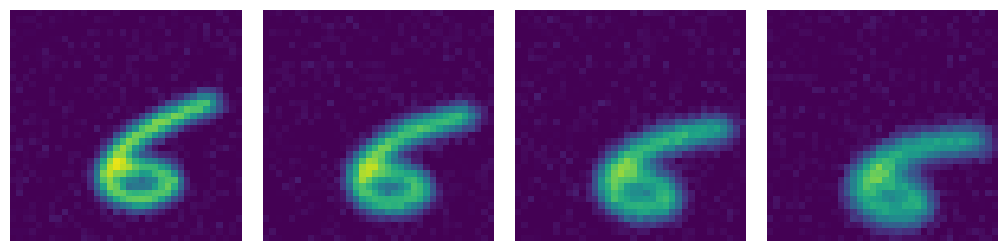

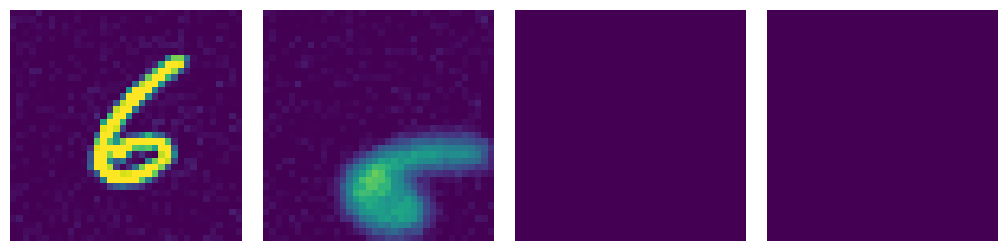

In [830]:
from openstl.utils import show_video_line

inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 14
show_video_line(inputs[example_idx], ncols=pre_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
#show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=200, cbar=False, out_path=None, format='png', use_rgb=False)

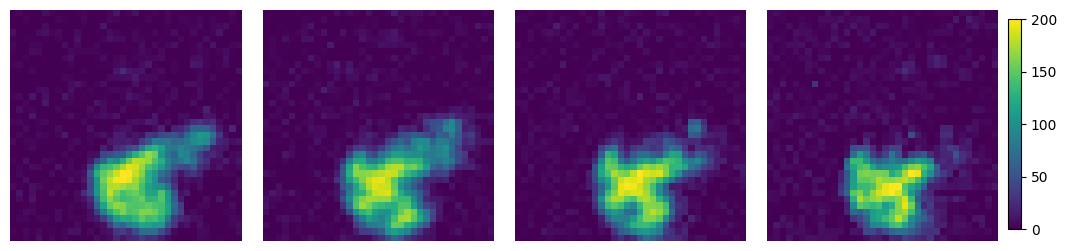

In [831]:
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=200,cmap='viridis', cbar=True, out_path=None, format='png', use_rgb=False)

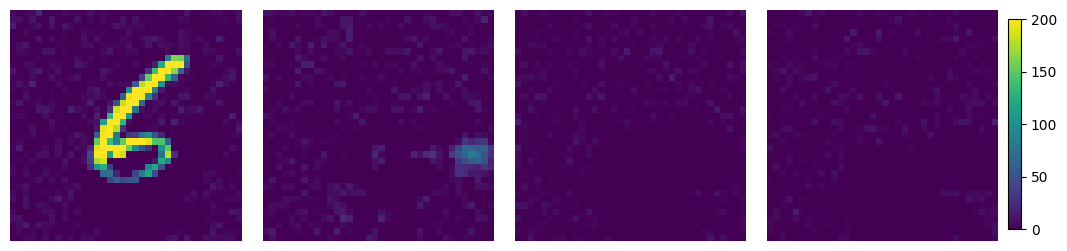

In [832]:
diff = trues - preds

show_video_line(diff[example_idx], ncols=aft_seq_length, vmax=200,cmap='viridis', cbar=True, out_path=None, format='png', use_rgb=False)

In [833]:
### 6. eVAL

### 6. Eval

In [834]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from skimage.metrics import structural_similarity as ssim

def metrics(trues, preds, idx_mid, sixor3,title):
  mse_values = []
  mae_values = []
  ssim_values = []
  if sixor3 == '6':
    period = 400
  else:
    period = 100

  for idx,img in enumerate(trues):
      i=idx

      if i > idx_mid-period-1 and i < idx_mid:

        true_image = trues[i][1][0]
        pred_image = preds[i][0][0]
        mse = mean_squared_error(true_image, pred_image)
        mse_values.append(mse)
        #mae
        mae = mean_absolute_error(true_image, pred_image)
        mae_values.append(mae)


        # SSIM
        ssim_score = ssim(true_image, pred_image, data_range=pred_image.max() - pred_image.min())
        ssim_values.append(ssim_score)
      else:
        if i > idx_mid-1 and i < idx_mid+period:
          true_image = trues[i][0][0]
          pred_image = preds[i][0][0]
          mse = mean_squared_error(true_image, pred_image)
          mse_values.append(mse)
          #mae
          mae = mean_absolute_error(true_image, pred_image)
          mae_values.append(mae)
          # SSIM
          ssim_score = ssim(true_image, pred_image, data_range=pred_image.max() - pred_image.min())
          ssim_values.append(ssim_score)



  avg_mse = np.mean(mse_values)
  avg_mae = np.mean(mae_values)
  avg_ssim = np.mean(ssim_values)

  print(title)
  print(f"Average MSE: {avg_mse}")
  print(f"Average MAE: {avg_mae}")
  print(f"Average SSIM: {avg_ssim}")
  return mse_values,mae_values,ssim_values, [avg_mse,avg_mae,avg_ssim]



In [835]:
mse1,mae1,ssim1,x6_data_all_res=metrics(trues,preds,400,'6','x6_data_all_res')

mse2,mae2,ssim2,x3_data_all_res=metrics(trues,preds,900,'3','x3_data_all_res')

mse3,mae3,ssim3,x6_data_all_blank_res=metrics(trues,preds,1400,'6','x6_data_all_blank')

mse4,mae4,ssim4,x3_data_all_blank_res=metrics(trues,preds,1900,'3','x3_data_all_blank')

mse5,mae5,ssim5,x6_data_all_noisy_res=metrics(trues,preds,2400,'6','x6_data_all_noisy')

mse6,mae6,ssim6,x3_data_all_noisy_res=metrics(trues,preds,2900,'3','x3_data_all_noisy')

mse7,mae7,ssim7,x6_data_b_and_noisy_res=metrics(trues,preds,3400,'6','x6_data_b_and_noisy')

mse8,mae8,ssim8,x3_data_b_and_noisy_res=metrics(trues,preds,3900,'3','x3_data_b_and_noisy')




x6_data_all_res
Average MSE: 528.8075832557678
Average MAE: 12.162395330667495
Average SSIM: 0.612658971915224
x3_data_all_res
Average MSE: 493.71072036743163
Average MAE: 12.039205079078675
Average SSIM: 0.610327119448772
x6_data_all_blank
Average MSE: 752.0086557388306
Average MAE: 14.143008031845092
Average SSIM: 0.42919777656338726
x3_data_all_blank
Average MSE: 720.273109741211
Average MAE: 13.952116751670838
Average SSIM: 0.42539352595559515
x6_data_all_noisy
Average MSE: 1387.8750283050538
Average MAE: 16.295101146101953
Average SSIM: 0.3116343292594725
x3_data_all_noisy
Average MSE: 1271.6102753448486
Average MAE: 15.76941517829895
Average SSIM: 0.30224724192135427
x6_data_b_and_noisy
Average MSE: 1577.2974221420288
Average MAE: 18.553054109811782
Average SSIM: 0.2506806407648835
x3_data_b_and_noisy
Average MSE: 1467.1592893981933
Average MAE: 17.918835716247557
Average SSIM: 0.24769006849032726


In [836]:
metrics_data = [
    {"Partition": "x6_data_all_res", "MSE": x6_data_all_res[0], "MAE": x6_data_all_res[1], "SSIM": x6_data_all_res[2]},
    {"Partition": "x3_data_all_res", "MSE": x3_data_all_res[0], "MAE": x3_data_all_res[1], "SSIM": x3_data_all_res[2]},
    {"Partition": "x6_data_all_blank", "MSE": x6_data_all_blank_res[0], "MAE": x6_data_all_blank_res[1], "SSIM": x6_data_all_blank_res[2]},
    {"Partition": "x3_data_all_blank", "MSE": x3_data_all_blank_res[0], "MAE": x3_data_all_blank_res[1], "SSIM": x3_data_all_blank_res[2]},
    {"Partition": "x6_data_all_noisy", "MSE": x6_data_all_noisy_res[0], "MAE": x6_data_all_noisy_res[1], "SSIM": x6_data_all_noisy_res[2]},
    {"Partition": "x3_data_all_noisy", "MSE": x3_data_all_noisy_res[0], "MAE": x3_data_all_noisy_res[1], "SSIM": x3_data_all_noisy_res[2]},
    {"Partition": "x6_data_b_and_noisy", "MSE": x6_data_b_and_noisy_res[0], "MAE": x6_data_b_and_noisy_res[1], "SSIM": x6_data_b_and_noisy_res[2]},
    {"Partition": "x3_data_b_and_noisy", "MSE": x3_data_b_and_noisy_res[0], "MAE": x3_data_b_and_noisy_res[1], "SSIM": x3_data_b_and_noisy_res[2]},
]

df = pd.DataFrame(metrics_data)

In [837]:
df

Partition          MSE        MAE      SSIM
0      x6_data_all_res   528.807583  12.162395  0.612659
1      x3_data_all_res   493.710720  12.039205  0.610327
2    x6_data_all_blank   752.008656  14.143008  0.429198
3    x3_data_all_blank   720.273110  13.952117  0.425394
4    x6_data_all_noisy  1387.875028  16.295101  0.311634
5    x3_data_all_noisy  1271.610275  15.769415  0.302247
6  x6_data_b_and_noisy  1577.297422  18.553054  0.250681
7  x3_data_b_and_noisy  1467.159289  17.918836  0.247690

In [838]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_path = f'/content/gdrive/MyDrive/MRes/metrics_summary_{timestamp}.csv'

df.to_csv(file_path, index=False)
print(f"DataFrame saved to: {file_path}")

DataFrame saved to: /content/gdrive/MyDrive/MRes/metrics_summary_20250113_080123.csv


In [839]:
import os
file_path = f'/content/gdrive/MyDrive/MRes/data_{timestamp}'

os.makedirs(file_path, exist_ok=True)

np.save(os.path.join(file_path, f'inputs_{timestamp}.npy'), inputs)
np.save(os.path.join(file_path, f'preds_{timestamp}.npy'), preds)
np.save(os.path.join(file_path, f'trues_{timestamp}.npy'), trues)

In [812]:
for idx,vla in enumerate(ssim3_values):
  if vla<0.5:
    print(idx+799)
    show_video_line(inputs[idx+799], ncols=pre_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
    show_video_line(trues[idx+799], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
    show_video_line(preds[idx+799], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)

Output hidden; open in https://colab.research.google.com to view.

In [747]:
for idx,vla in enumerate(mse3_values):
  if vla>900:
    print(idx+800)
    show_video_line(inputs[idx+799], ncols=pre_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
    show_video_line(trues[idx+799], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
    show_video_line(preds[idx+799], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)

Output hidden; open in https://colab.research.google.com to view.

In [881]:
## Output csv's

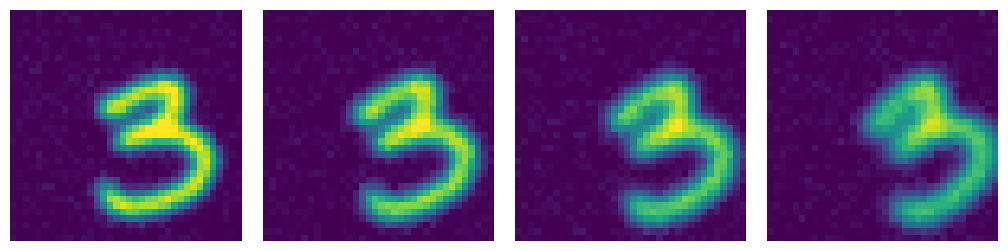

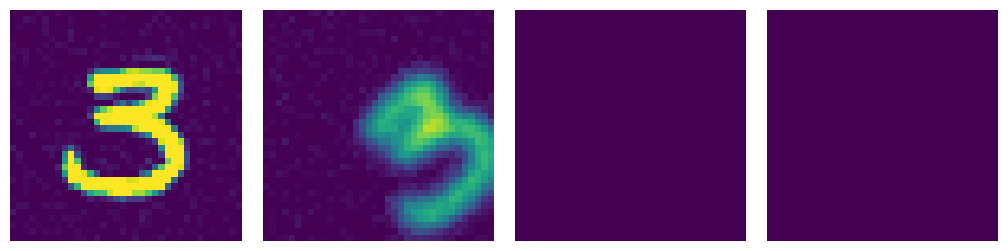

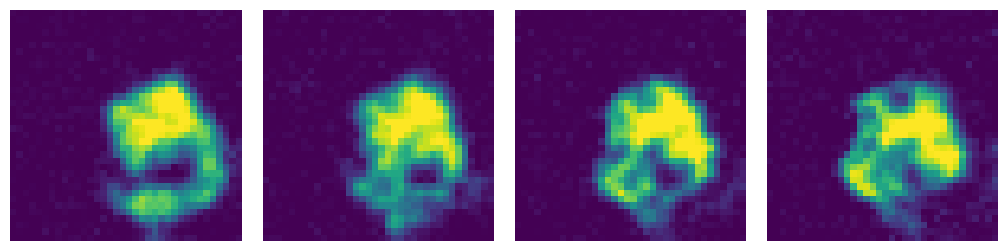

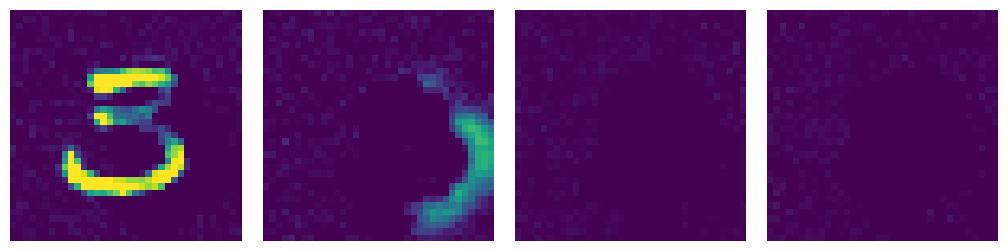

In [882]:
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('/content/gdrive/MyDrive/MRes/data_20250113_035300/inputs_20250113_035300.npy')
preds = np.load('/content/gdrive/MyDrive/MRes/data_20250113_035300/preds_20250113_035300.npy')
trues = np.load('/content/gdrive/MyDrive/MRes/data_20250113_035300/trues_20250113_035300.npy')

example_idx = 800
show_video_line(inputs[example_idx], ncols=pre_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
diff = trues - preds
show_video_line(diff[example_idx], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)

In [926]:
len(preds)
output = []
for i in range(400):
  if i < 400:
    output.append(preds[i+400][0][0].flatten().tolist())
    output.append(preds[i][0][0].flatten().tolist())


#output[0]



In [927]:
preds[0][0][0]

array([[-2.8573    , -3.3837652 ,  5.313335  , ..., -5.19567   ,
        -6.698891  ,  6.017129  ],
       [ 0.93613064, -5.683768  , -1.0842637 , ..., -2.767902  ,
        -2.137388  , -6.1845064 ],
       [-4.12535   , -3.1610315 , -6.3268013 , ...,  0.08491471,
         6.3482056 , -4.504568  ],
       ...,
       [ 6.5877275 , -0.50573325,  1.8368781 , ...,  0.29925272,
        -4.709783  ,  1.7987903 ],
       [ 3.2637784 ,  0.6248503 , -4.884446  , ..., -4.6210337 ,
        -0.8638545 , -4.061113  ],
       [-2.1395218 ,  1.8984214 ,  0.87056005, ...,  1.057089  ,
        -2.246973  , -1.6261673 ]], dtype=float32)

In [928]:

df = pd.DataFrame(output)

In [929]:
df.to_csv('/content/gdrive/MyDrive/MRes/n6_test_jm.csv', index=False,header=False)

In [931]:
output_Checkn6 = genfromtxt('/content/gdrive/MyDrive/MRes/n6_test_jm.csv', delimiter=',')
output_Checkn6_arr=basic_data_loader(output_Checkn6,'test')

In [932]:
output_Checkn6_arr[0][0]

array([[ -4.24416256,  -2.76298022,  -4.15445328, ...,   2.64954352,
          5.33012724,  -4.21424913],
       [  1.74854183,   0.24293385,   0.20005548, ..., -10.40250969,
          2.71292925,  -0.78648221],
       [  2.86409593,   1.03439772,   0.71139199, ...,   1.53033185,
          1.15448892,   5.12203264],
       ...,
       [  1.85196793,  -0.42726418,   6.391747  , ...,   2.02577662,
         -1.01275694,   3.80752635],
       [  6.88137674,  -0.315671  ,  -2.2381475 , ...,   3.231812  ,
          0.54566169,  -2.01379848],
       [  1.66762555,   5.90943909,   3.13612723, ...,  -3.27582312,
          2.48557043,   2.39452863]])

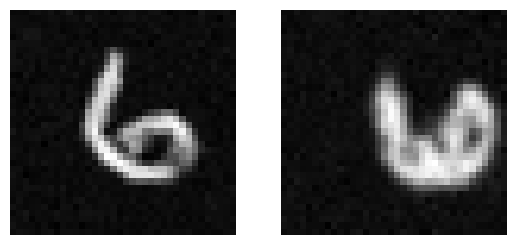

In [933]:
plot_seq(output_Checkn6_arr,'Test')

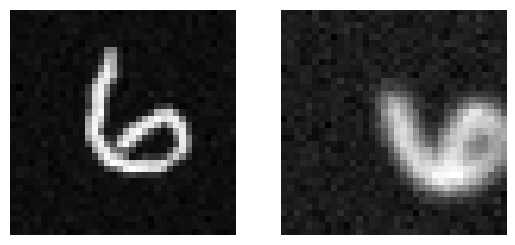

In [934]:
plot_seq(test6_arr,'Test')

In [935]:
OUTPUTCHK_sequences = np.split(output_Checkn6_arr[0], 400)

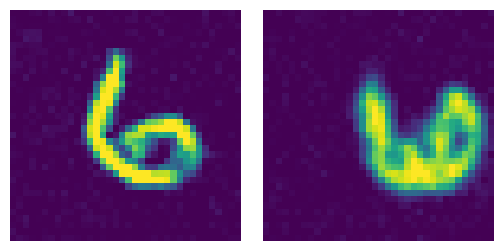

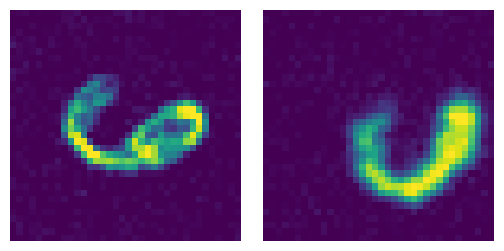

In [940]:
for idx,seq in enumerate(OUTPUTCHK_sequences):
  if idx<2:
    show_video_line(seq, ncols=2, vmax=200,cmap='viridis')


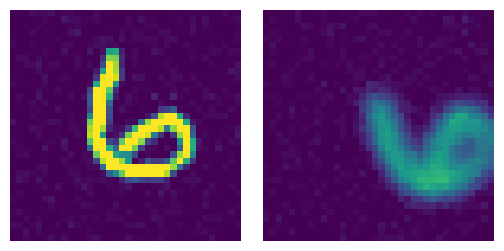

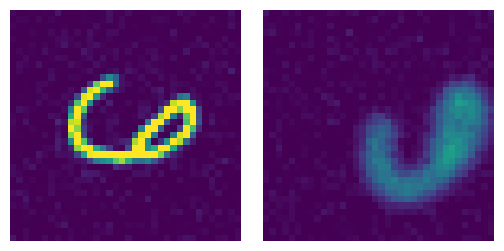

In [941]:
for idx,seq in enumerate(test6_sequences):
  if idx<2:
    show_video_line(seq, ncols=2, vmax=200,cmap='viridis')


In [948]:
###n3
len(preds)
output = []
for i in range(100):
  if i < 100:
    output.append(preds[i+900][0][0].flatten().tolist())
    output.append(preds[i+800][0][0].flatten().tolist())


#output[0]

df = pd.DataFrame(output)

df.to_csv('/content/gdrive/MyDrive/MRes/n3_test_jm2.csv', index=False,header=False)
output_Checkn3 = genfromtxt('/content/gdrive/MyDrive/MRes/n3_test_jm2.csv', delimiter=',')
output_Checkn3_arr=basic_data_loader(output_Checkn3,'test')

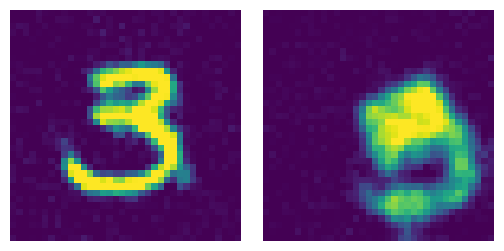

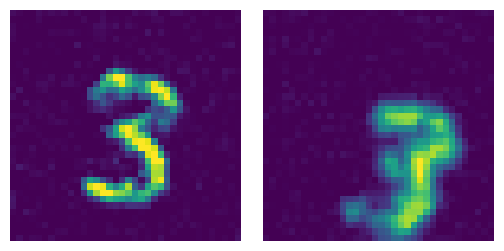

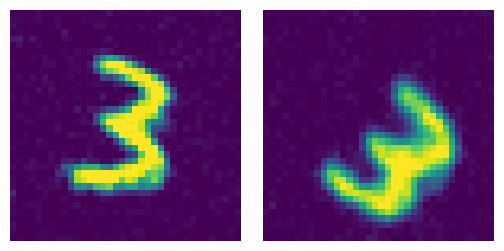

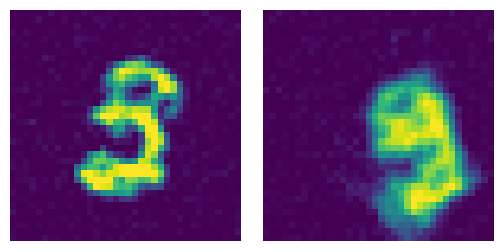

In [952]:
OUTPUTCHK3_sequences = np.split(output_Checkn3_arr[0], 100)
for idx,seq in enumerate(OUTPUTCHK3_sequences):
  if idx<4:
    show_video_line(seq, ncols=2, vmax=200,cmap='viridis')


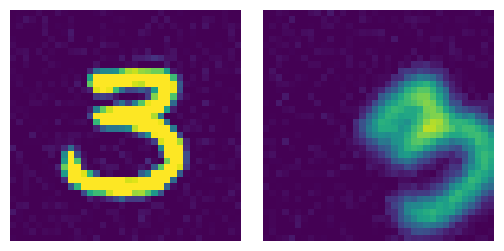

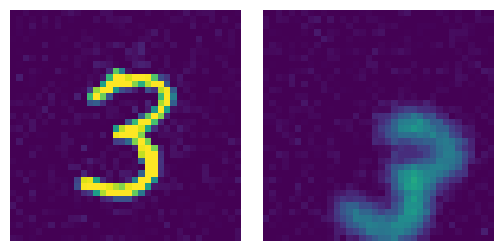

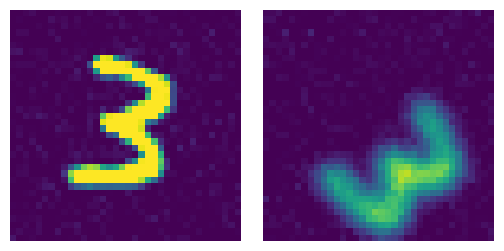

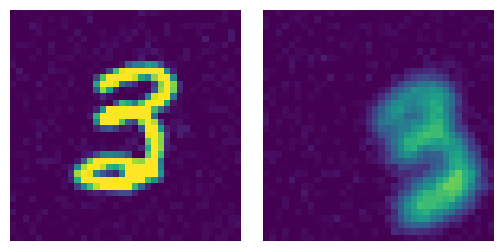

In [953]:
for idx,seq in enumerate(test3_sequences):
  if idx<4:
    show_video_line(seq, ncols=2, vmax=200,cmap='viridis')


In [958]:
### Qualitative


In [959]:
mse1,mae1,ssim1,x6_data_all_res=metrics(trues,preds,400,'6','x6_data_all_res')

mse2,mae2,ssim2,x3_data_all_res=metrics(trues,preds,900,'3','x3_data_all_res')

mse3,mae3,ssim3,x6_data_all_blank_res=metrics(trues,preds,1400,'6','x6_data_all_blank')

mse4,mae4,ssim4,x3_data_all_blank_res=metrics(trues,preds,1900,'3','x3_data_all_blank')

mse5,mae5,ssim5,x6_data_all_noisy_res=metrics(trues,preds,2400,'6','x6_data_all_noisy')

mse6,mae6,ssim6,x3_data_all_noisy_res=metrics(trues,preds,2900,'3','x3_data_all_noisy')

mse7,mae7,ssim7,x6_data_b_and_noisy_res=metrics(trues,preds,3400,'6','x6_data_b_and_noisy')

mse8,mae8,ssim8,x3_data_b_and_noisy_res=metrics(trues,preds,3900,'3','x3_data_b_and_noisy')




x6_data_all_res
Average MSE: 876.9299685287475
Average MAE: 14.79376537322998
Average SSIM: 0.5643972499664652
x3_data_all_res
Average MSE: 800.9186114501953
Average MAE: 14.396060719490052
Average SSIM: 0.5674510220376141
x6_data_all_blank
Average MSE: 877.2810000801087
Average MAE: 14.786196509599685
Average SSIM: 0.562637762958379
x3_data_all_blank
Average MSE: 800.2327146911621
Average MAE: 14.373935647010804
Average SSIM: 0.5664722620967387
x6_data_all_noisy
Average MSE: 999.0963188171387
Average MAE: 15.473890929222106
Average SSIM: 0.5446001110683394
x3_data_all_noisy
Average MSE: 911.8433000183105
Average MAE: 15.039981927871704
Average SSIM: 0.5461378221224642
x6_data_b_and_noisy
Average MSE: 1000.4443959617615
Average MAE: 15.468366863727569
Average SSIM: 0.5439246540045987
x3_data_b_and_noisy
Average MSE: 884.8592248535156
Average MAE: 14.87211130619049
Average SSIM: 0.5500779863219928


21


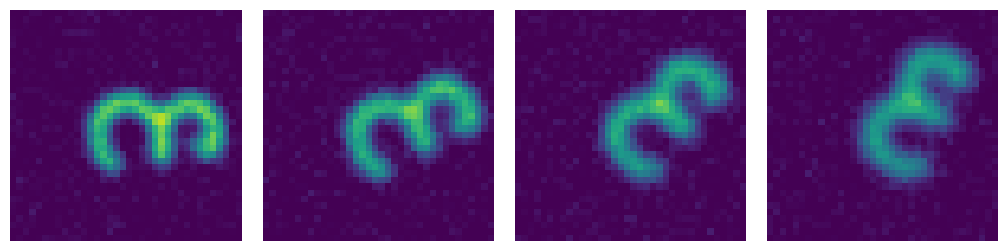

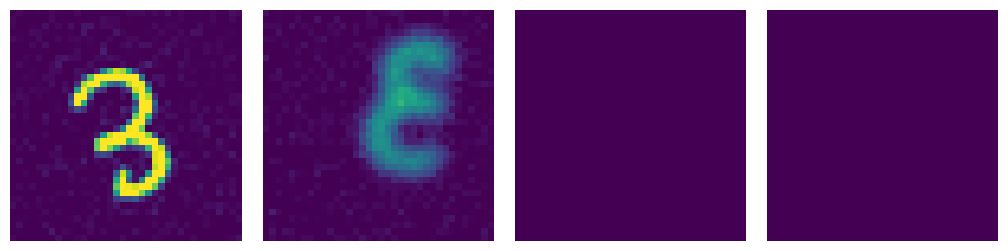

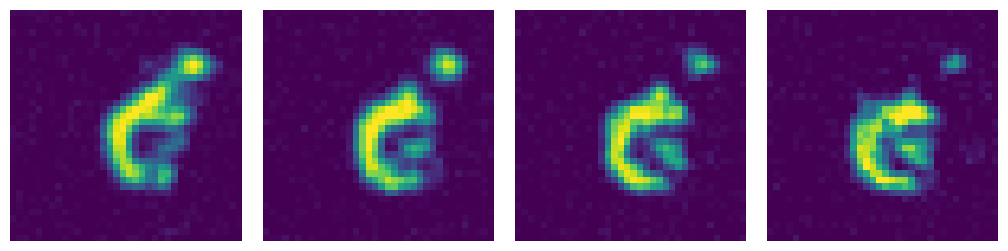

24


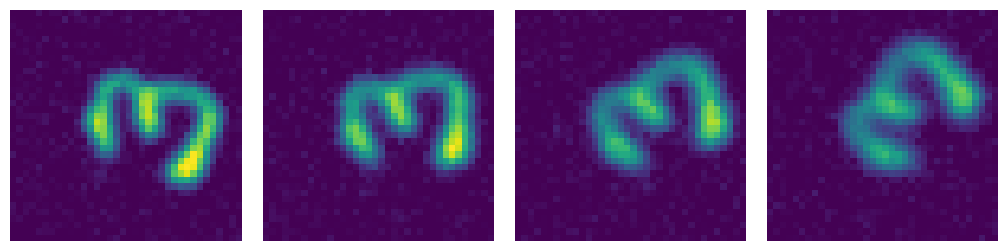

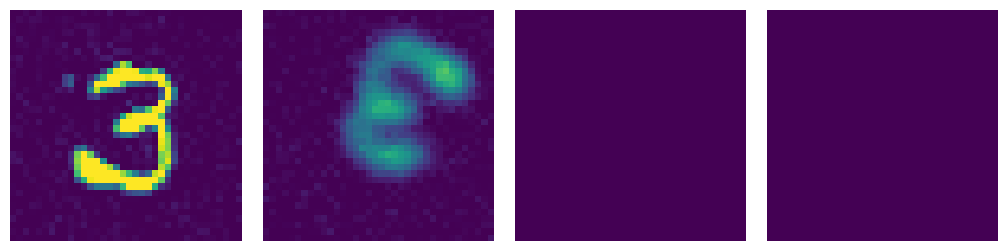

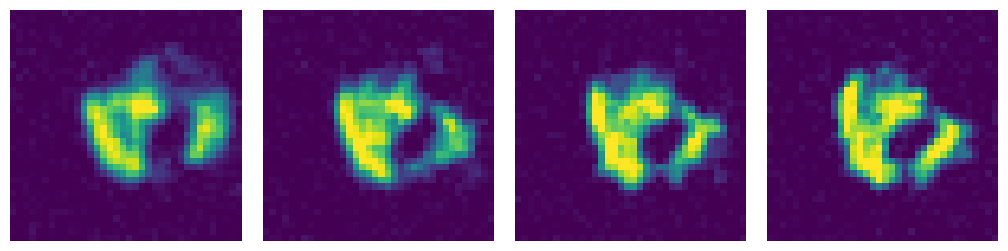

25


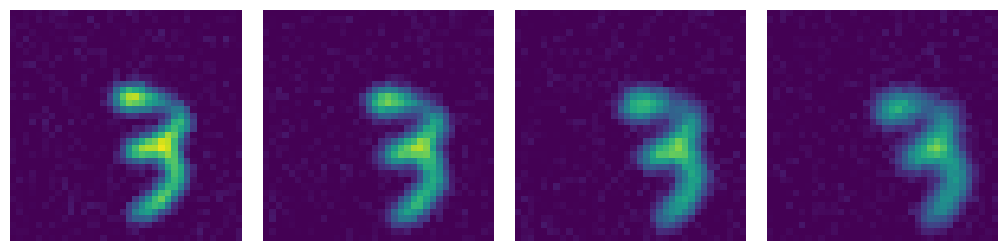

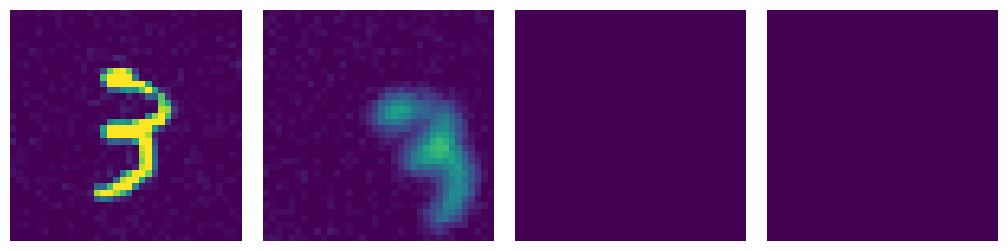

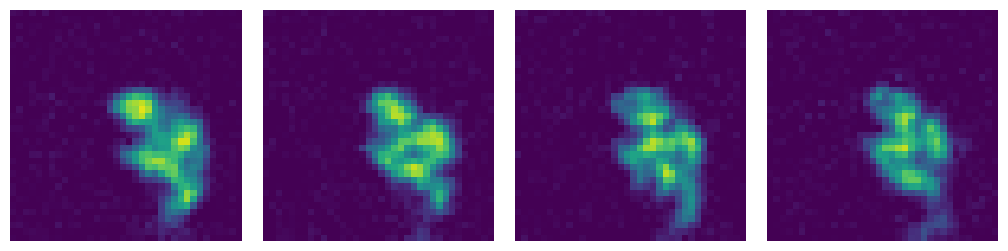

54


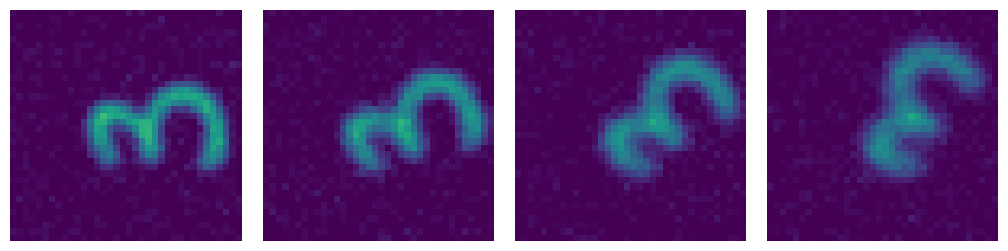

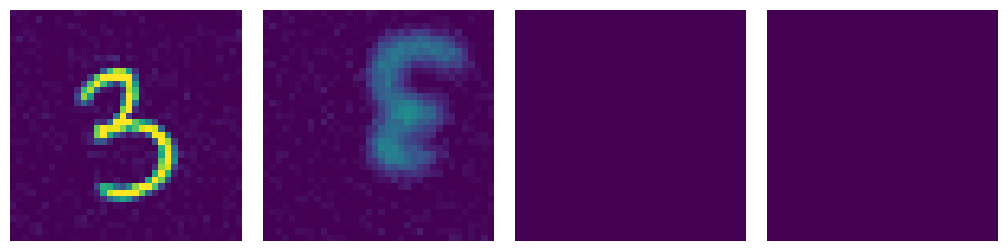

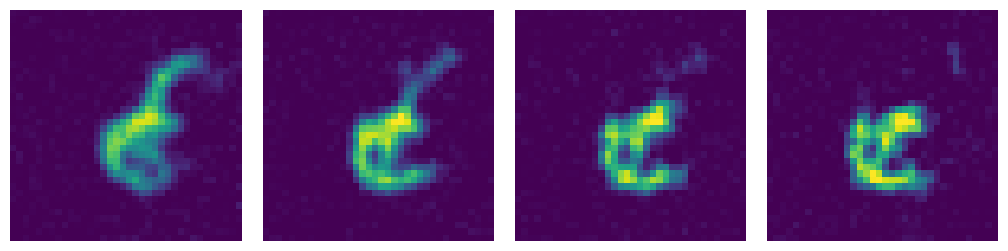

61


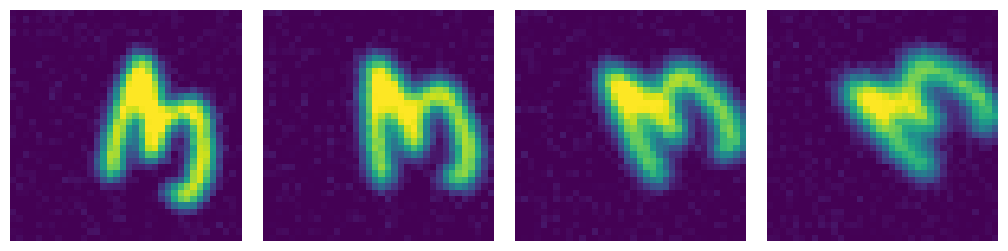

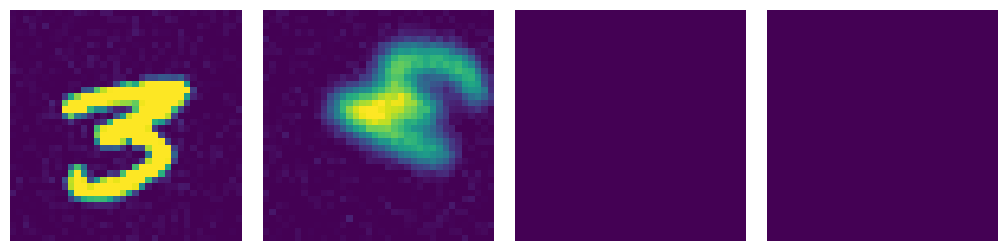

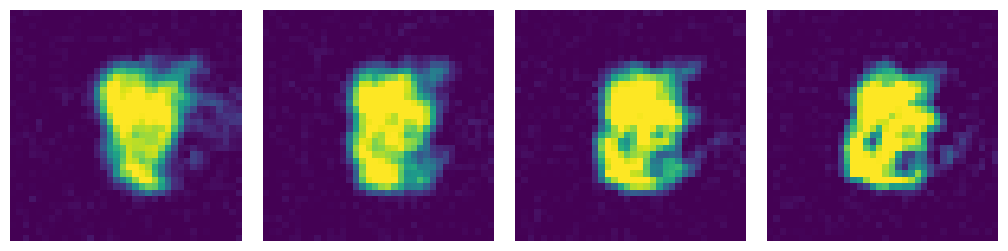

64


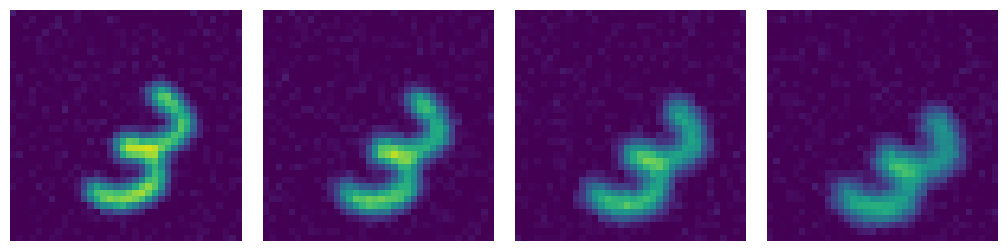

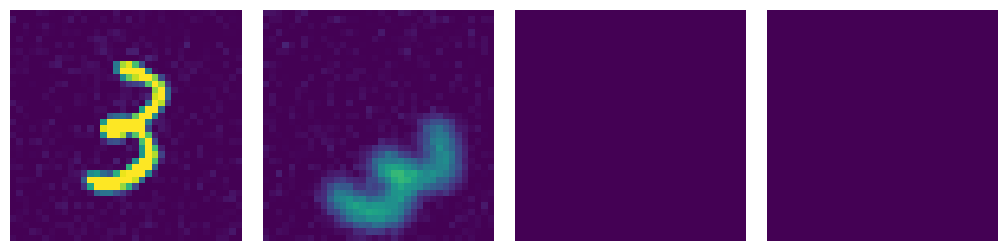

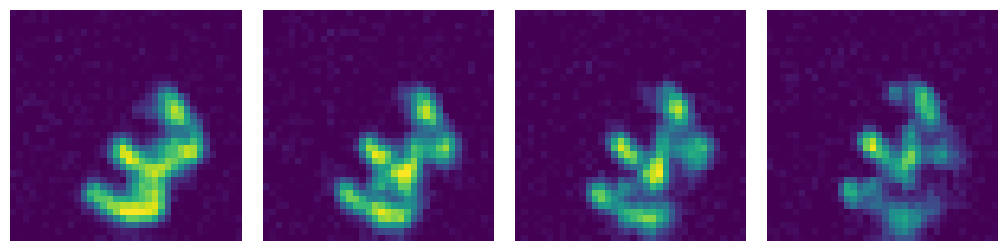

78


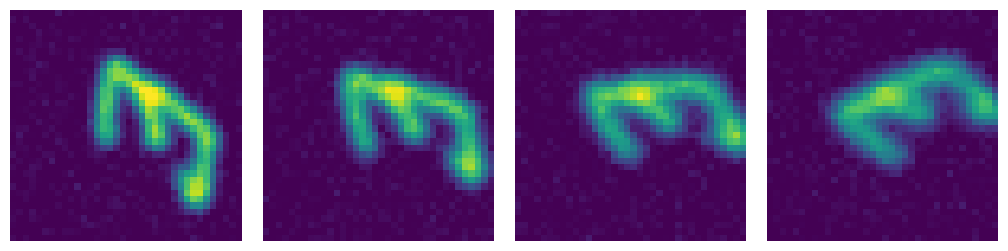

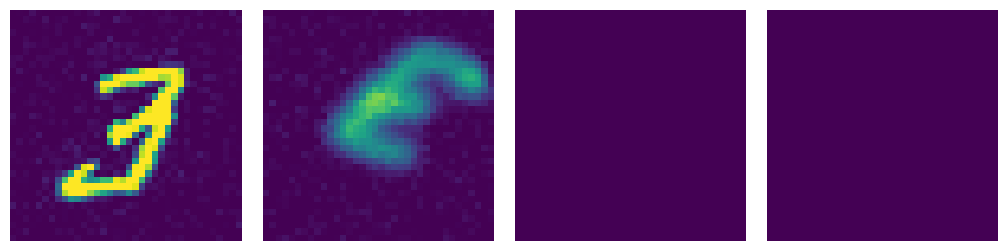

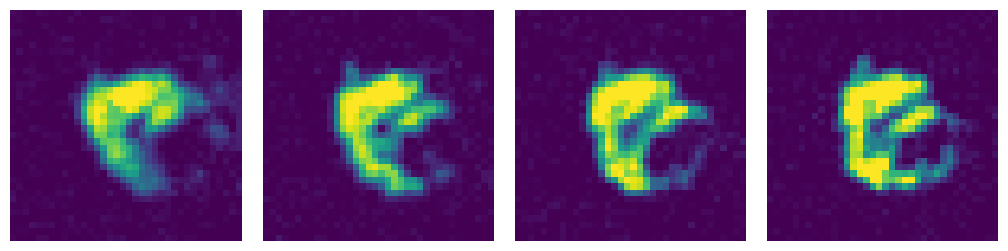

87


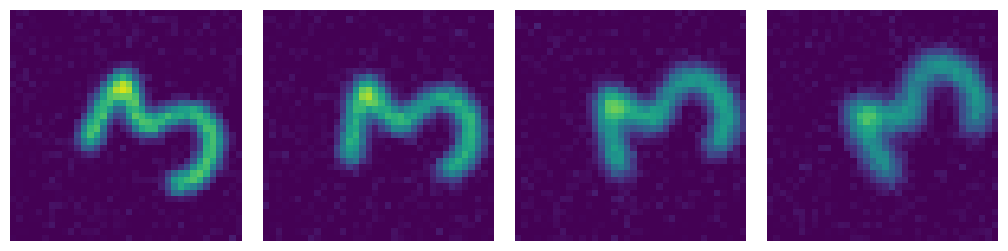

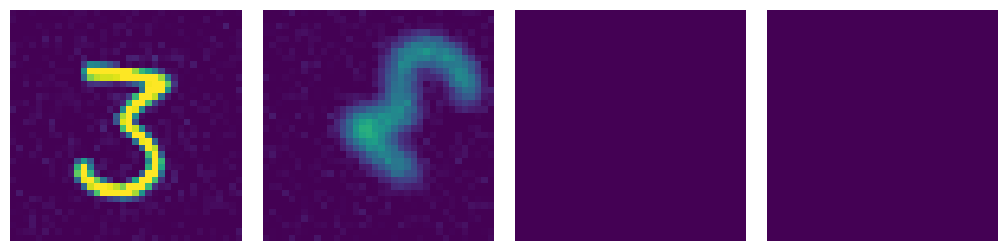

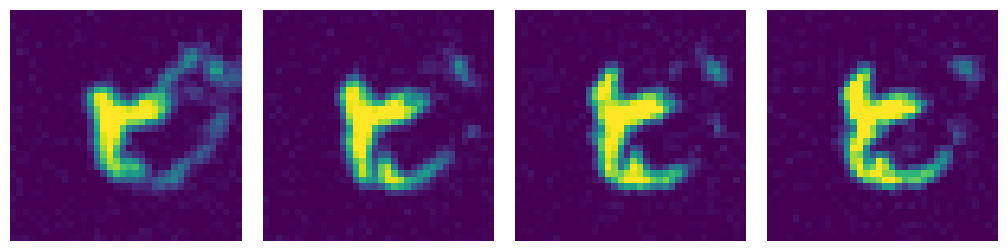

In [1007]:
for idx,val in enumerate(ssim2):
  if val<0.4:
    print(idx)
    show_video_line(inputs[800+idx], ncols=pre_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
    show_video_line(trues[800+idx], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)
    show_video_line(preds[800+idx], ncols=aft_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)

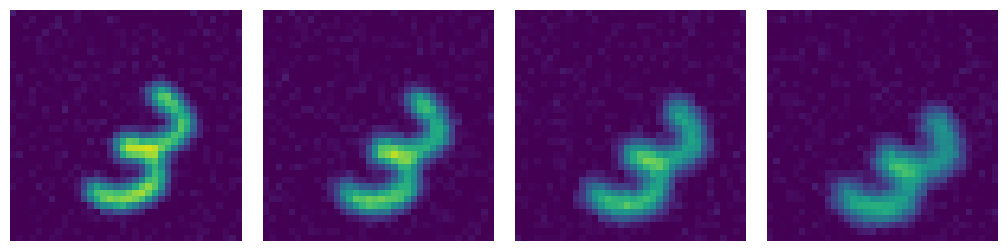

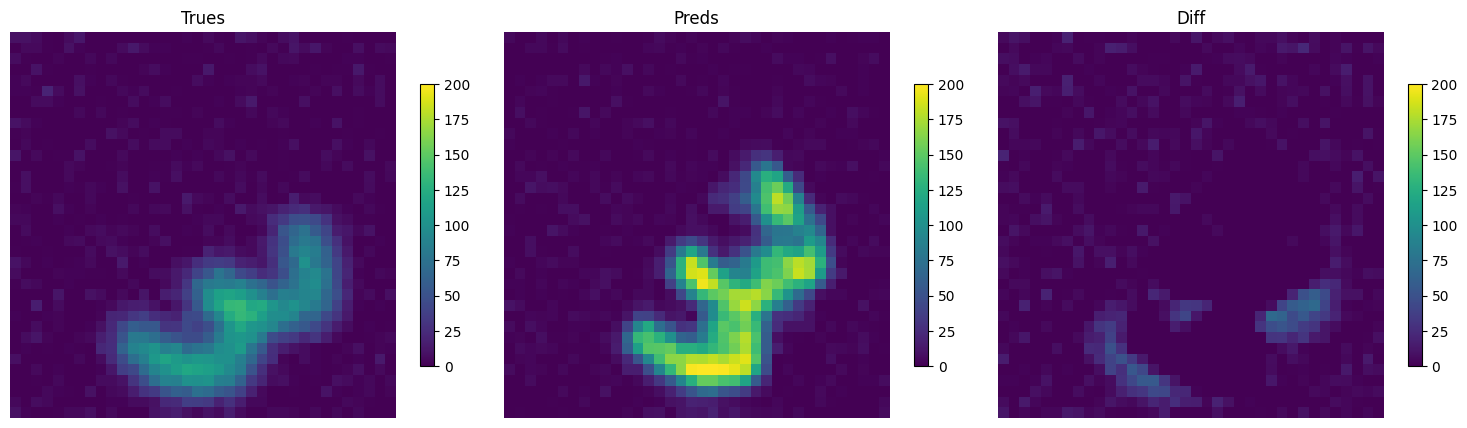

In [1009]:
#idxs=711,350
#idxbad = 26,91
#Idxaug=3627
#idxaugbad = 103,157
#idx3_good= 22
example_idx = 864
show_video_line(inputs[example_idx], ncols=pre_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed


axes[0].imshow(trues[example_idx][1][0], cmap='viridis',vmin=0,vmax=200)
axes[0].set_title('Trues')
axes[0].axis('off')  # Turn off axis ticks and labels


axes[1].imshow(preds[example_idx][0][0], cmap='viridis',vmin=0,vmax=200)
axes[1].set_title('Preds')
axes[1].axis('off')

diff_image = trues[example_idx][1][0] - preds[example_idx][0][0]
axes[2].imshow(diff_image, cmap='viridis',vmin=0,vmax=200)
axes[2].set_title('Diff')
axes[2].axis('off')

# Add colorbars
plt.colorbar(axes[0].images[0], ax=axes[0], shrink=0.6)
plt.colorbar(axes[1].images[0], ax=axes[1], shrink=0.6)
plt.colorbar(axes[2].images[0], ax=axes[2], shrink=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

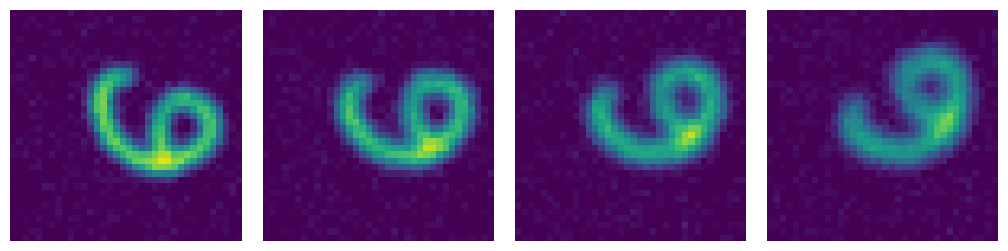

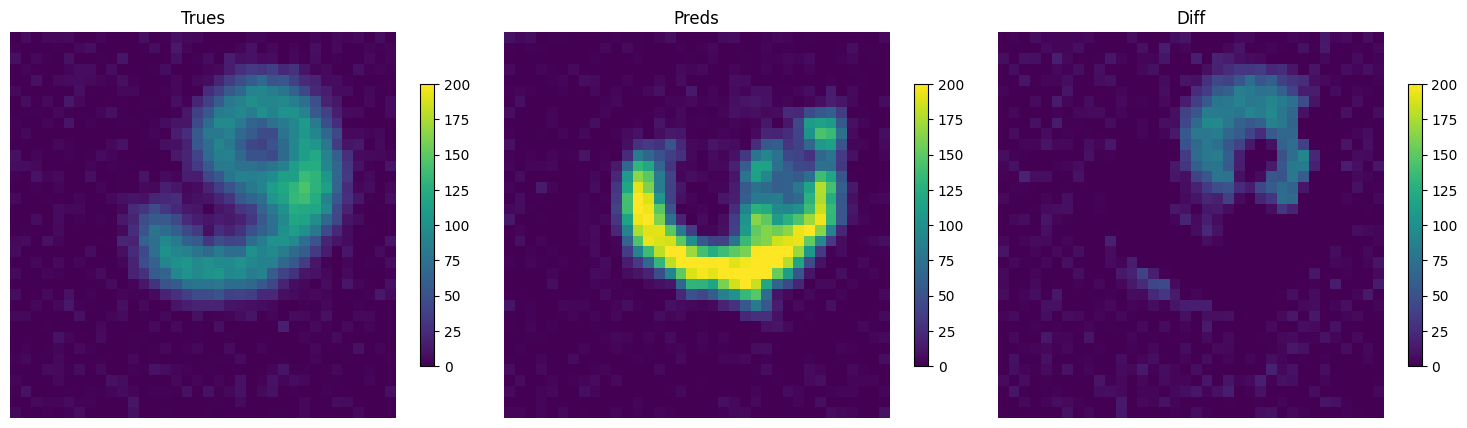

In [983]:
#idxs=711,350

example_idx = 26
show_video_line(inputs[example_idx], ncols=pre_seq_length, vmax=200, cbar=False,cmap='viridis', out_path=None, format='png', use_rgb=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed


axes[0].imshow(trues[example_idx][1][0], cmap='viridis',vmin=0,vmax=200)
axes[0].set_title('Trues')
axes[0].axis('off')  # Turn off axis ticks and labels


axes[1].imshow(preds[example_idx][0][0], cmap='viridis',vmin=0,vmax=200)
axes[1].set_title('Preds')
axes[1].axis('off')

diff_image = trues[example_idx][1][0] - preds[example_idx][0][0]
axes[2].imshow(diff_image, cmap='viridis',vmin=0,vmax=200)
axes[2].set_title('Diff')
axes[2].axis('off')

# Add colorbars
plt.colorbar(axes[0].images[0], ax=axes[0], shrink=0.6)
plt.colorbar(axes[1].images[0], ax=axes[1], shrink=0.6)
plt.colorbar(axes[2].images[0], ax=axes[2], shrink=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()